# Neural Networks 
# Lab 1 - Part 2 : Kaggle dataset
## Out-of-the box & SVM & Results
---


Η διαδικασία είναι παρόμοια σε αρκετά σημεία με εκείνη που ακολουθήθηκε για το 1ο μέρος της άσκησης.  Η εξήγησή της στο 2ο μέρος θα είναι λοιπόν πιο συνοπτική σε κάποια σημεία (π.χ. ορισμό pipelines). 

 Κάποιες φορές τα plots του optuna αργούν να εμφανιστούν ή δεν εμφανίζονται. Τα links για τα notebooks (shared with: Giorgos Siolas) αυτά στο kaggle όπου φαίνονται κανονικά τα outputs του optuna είναι:


* [mpl optimization](https://www.kaggle.com/code/marglr/lab1-part2-mlp-optimization/notebook)

* [out-of-the-box & SVM & conclusions](https://www.kaggle.com/marglr/lab1-part2-all-but-mlp/notebook)



In [3]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline

# import scikit-learn models
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
# Import classes for preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import optuna

#colors for plots
colors= ["#588c7e", "#96ceb4" ,"#b5e7a0","#86af49", "#e3eaa7"]

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data = pd.read_csv("../input/condon-usage-dataset/codon_usage.csv")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/condon-usage-dataset/codon_usage.csv


In [4]:
def show_confusion_matrix(estimator, X_test, y_test, title):
    """
    παράγει το πλοτ του confusion matrix (και το εκτυπώνει)
    """
    plt.figure(figsize=(10,10))
    y_pred = estimator.predict(X_test)
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(11,11)
    sns.heatmap(cf_matrix, annot = labels, fmt='', cmap='Blues')
    plt.title(title)
    plt.show()
def balance(X_train, y_train, m=300):
    """
    balances train set so all classes consist of m samples 
    """
    #we are going to use both over & under sampler in order to have m elements of each class in train set
    
    # # elements of each class in train set:
    elements = [101, 2334, 1070, 458, 176, 14, 2013, 144, 172, 2265, 1661]
    #need for the oversampling
    max_ = max(elements)
    
    sampling_strategy = {}
    for i, count in enumerate(elements):
        if count > m:
            sampling_strategy[i]= max_
        else:
            sampling_strategy[i] = m

    ros = RandomOverSampler(sampling_strategy=sampling_strategy)
    ros = RandomOverSampler(sampling_strategy=sampling_strategy)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    for i, count in enumerate(elements):
            sampling_strategy[i]= m
    ros = RandomUnderSampler(sampling_strategy=sampling_strategy)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
    return X_train, y_train   

def evaluate_best(estimator, X_train, X_test, y_train, y_test, metric, m):
    """
    εκτυπώνει το classification report και επιστρέφει τον χρόνο εκπαίδευσης στο X_train, τον χρόνο στο X_test και την 
    τιμή της μετρικής metric που δίνεται ως είσοδο για τον ταξινομητή estimator.
    
    #balance train set 
    #we are going to use both over & under sampler in order to have m elements of each class in train set
    
    """
   
    X_train, y_train = balance(X_train, y_train, m)
    
    start_time = time.time()
    # fit on train dataset
    estimator.fit(X_train, y_train)
    train_time = time.time() - start_time

    # evauate on test dataset
    start_time = time.time()
    preds = estimator.predict(X_test)
    print(classification_report(y_test, preds))
    test_time = time.time() - start_time
    performance = classification_report(y_test, preds,output_dict='True')[metric]

    return performance, train_time, test_time



## Εισαγωγή και Επισκόπηση
---
* Εισάγουμε το σύνολο των δεδομένων **K06 (Codon Usage Dataset)** του Kaggle. Στο πρόβλημα που περιγράφει το dataset ο σκοπός είναι να ταξινομηθεί ένας δεδομένος οργανισμός στο ζωικό βασίλειο που ανήκει χρησιμποιώντας τις συχνότητες εμφάνισης κωδικόνιων (δηλαδή τριπλετών από αζωτούχες βάσεις) στο DNA ποικίλων βιολογικών οργανισμών.

* Τα δεδομένα του dataset K06 όπως δίνονται από το Kaggle σε ένα ".csv" αρχείο τα οποία διαβάζουμε με χρήση της συνάρτησης read_csv της pandas βιβλιοθήκης. Δεν χρειάζεται κάποια επιπλέον λειτουργία (πχ concatenation αρχείων) για την ανάγνωση των δεδομένων.

* Για κάθε στήλη υπάρχουν **επικεφαλίδες** που κατονομάζουν το αντίστοιχο feature.  Πιο συγκεκριμένα, η γραμμή της επικεφαλίδας παρέχει τις κεφαλίδες στηλών 'Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'Species Name', ακολουθούμενες από τα προσδιοριστικά τριών γραμμάτων των 64 διαφορετικών κωδικώνων (π.χ. 'AUG'). Oι **ετικέτες** των δειγμάτων βρίσκονται στην πρώτη κολώνα ('Kindom'). 
Οι γραμμές είναι αριθμημένες (από 0 έως 13027).

* Το dataset αποτελείται από 13028 δείγματα.
 Για κάθε ένα από αυτά δίνονται 68 χαρακτηριστικά. Έχουμε 69 κολόνες από τις οποίες η **1η είναι το label** κάθε δείγματος. 
 Τα χαρακτηριστικά αυτά αναγράφονται με την σειρά των κολώνων (2 - 69, η 1η είναι το label) παρακάτω:
    - **DNAtype** (2η κολώνα): αφορά τον τύπο DNA του κάθε οργανισμού - δείγματος. Παίρνει ακέραιες τιμές, συγκεκριμένα από 0 έως 12 κάθε μία από τις οποίες αντιστοιχεί σε μία από τις 13 τιμές τύπου DNA ως εξής: 
        * 0-genomic
        * 1-mitochondrial
        * 2-chloroplast
        * 3-cyanelle
        * 4-plastid
        * 5-nucleomorph
        * 6-secondary_endosymbiont
        * 7-chromoplast
        * 8-leucoplast
        * 9-NA
        * 10-proplastid
        * 11-apicoplast
        * 12-kinetoplast
 
     Πρόκειται για **μη-διατεταγμένο κατηγορικό χαρακτηριστικό**. Κρίνουμε ότι μπορεί να βοηθήσει στο πρόβλημα κατηγοριοποίησης και έτσι το κρατάμε.Η αριθμητική αναπαράσταση που χρησιμοποιεί το dataset είναι κομψή όμως θεωρεί ότι το σύνολο τιμών της κατηγορικής μεταβλητής είναι διατετεγμένο πράγμα που δεν ισχύει και θα οδηγήσει τον ταξινομητή σε λάθη. Διαπιστώνουμε ότι 2 από αυτές τις τιμές δεν εμφανίζονται καθόλου. Έτσι, θα το μετατρέψουμε σε binary χαρακτηριστικά (όσα και οι διαφορετικές τιμές) από τα οποία μόνο ένα είναι ενεργό κάθε φορά. Παρατηρούμε ότι περίπου το 71% των δειγμάτων έχουν DNAtype = 0, το 22% 1 και το 6% 2. Για καθένα από τα υπόλοιπα DNA types έχουμε < 0.05% των δειγμάτων (εκτός από το 4 που έχουμε 0.24%). Θα δοκιμάσουμε να αφαιρέσουμε σειρές που δεν έχουν DNAtype 0, 1 ή 2 (ώστε να αποφύγουμε τους υπόλοιπους DNAtypes που δεν εμφανίζονται ιδιαίτερα στο dataset και επομένως δεν μπορούν να του δώσουν κάποια χρήσιμη γνώση).
    - **SpeciesID**: είναι ένας ακέραιος που δηλώνει το είδος του γονιδιώματος.  Είναι εμφανές ότι δεν προσφέρει κάποια χρήσιμη πληροφορία για το πρόβλημα κατηγοριοποίησης οπότε θα διαγράψουμε την στήλη αυτή (drop). Παίρνει πάρα πολλές διαφορετικές τιμές καθόλο το dataset και έχουμε το πολύ 4 δείγματα πουνα έχουν το ίδιο SpeciesID. Δεν υπάρχει λοιπόν λόγος να την κρατήσουμε καθώς πέραν της επιβράδυνσης του μοντέλου μπορεί να το μπερδεύει. 
    - **Ncodons**: αφορά στον συνολικό αριθμό των κωδικονίων του DNA κάθε οργανισμού - δείγμα, με βάση τον οποίο εξάγονται και οι συχνότητες εμφάνισής τους. Πρόκειται για *integer μεταβλητή* που δεν φαίνεται να συνεισφέρει στο πρόβλημα κατηγοριοποίησης οπότε την διαγράφουμε. Θα δοκιμάσουμε πρωτού το κάνουμε αυτό να αφαιρέσουμε τα δείγματα με genome με λιγότερα από 1000 κωδικόνια (θεωρώντας ότι δεν είναι τόσο αξιόπιστα).
    - **SpeciesName**: δίνει το περιγραφικό όνομα του είδους για κάθε δείγμα - οργανισμό. Παίρνει πάρα πολλές διαφορετικές τιμές καθόλο το dataset και έχουμε το πολύ 4 δείγματα που να ανήκουν στο ίδιο είδος (να έχουν το ίδιο επιστημονικό όνομα είδους). Έτσι κρίνουμε ότι δεν μπορούμε να το χρησιμοποιήσουμε για το πρόβλημα της ταξινόμησης και για αυτό θα κάνουμε drop την κολώνα αυτή.
    - Οι **κολώνες 6-69** αφορούν τις συχνότητες εμφάνισης κωδωνίων και είναι *continuous variables* (floats with decimals in 5 digits) που θα επιτελέσουν τον κυρίαρχο ρόλο στο πρόβλημα κατηγοριοποίησης. 

* Πρόκειται για ένα **Multiclass Classification problem** και οι ετικέτες των κλάσεων είναι οι εξής **11**: 
   * 'arc'(archaea)
   * 'bct'(bacteria)
   * 'phg'(bacteriophage)
   * 'plm' (plasmid)
   * 'pln' (plant)
   * 'inv' (invertebrate)
   * 'vrt' (vertebrate)
   * 'mam' (mammal)
   * 'rod' (rodent)
   * 'pri' (primate)
   * 'vrl'(virus)
   
  Πρόκειται για το το ζωικό βασίλειο στο οποίο κατατάσσεται ο κάθε οργανισμός - δείγμα. Όπως προαναφέρθηκε, βρίσκονται στην 1η κολώνα που ονομάζεται **Kingdom**. 
  
* Υπάρχουν απουσιάζουσες τιμές. Για την ακρίβεια υπάρχουν όπως θα δούμε παρακάτω 2 γραμμές στο dataset με **λανθασμένες τιμές** στην στήλη UUU και 1 στην UUC. Δεν μπορούμε να τις χρησιμοποιήσουμε και είναι πολύ λίγες οπότε διαγράφουμε εξ'ολοκλήρου τις γραμμές αυτές.

* Όπως προαναφέρθηκε το πλήθος των κλάσεων του προβλήματος είναι 11. Για να δούμε αν το dataset μας είναι ισορροπημένο ή μη θα δούμε πόσα δείγματα έχουμε ανά κατηγορία στο training set. To dataset **δεν είναι ισορροπημένο**. Περίπου το 22% των δειγμάτων είναι bacteria, ένα άλλο 22% είναι vrl (vertebrates) και το υπόλοιπο 56% κατανέμεται στις υπόλοιπες κλάσεις.


In [5]:
nan_in_df = data.isnull().sum().sum()
print(f"Number of NaN values present in dataset is {nan_in_df}")
data.info()

Number of NaN values present in dataset is 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13028 entries, 0 to 13027
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kingdom      13028 non-null  object 
 1   DNAtype      13028 non-null  int64  
 2   SpeciesID    13028 non-null  int64  
 3   Ncodons      13028 non-null  int64  
 4   SpeciesName  13028 non-null  object 
 5   UUU          13028 non-null  object 
 6   UUC          13028 non-null  object 
 7   UUA          13028 non-null  float64
 8   UUG          13028 non-null  float64
 9   CUU          13028 non-null  float64
 10  CUC          13028 non-null  float64
 11  CUA          13028 non-null  float64
 12  CUG          13028 non-null  float64
 13  AUU          13028 non-null  float64
 14  AUC          13028 non-null  float64
 15  AUA          13028 non-null  float64
 16  AUG          13028 non-null  float64
 17  GUU          13028 non-null  float64
 18  G

## Προετοιμασία Δεδομένων
---

In [6]:
print('There are {} rows and {} columns in the data.'.format(data.shape[0],data.shape[1]))
print("-----------------------------------------------")
cat_columns = [col for col in data.columns[:5]] #if data[col].dtype=='O']
for col in cat_columns:
    print('Unique value for {} (#:{}):'.format(col,len(data[col].unique())))
    print(data[col].value_counts())
    if (col == 'Kingdom' or col == 'DNAtype'):
        print("\nin percentage form: \n", [np.round(class_/data.shape[0]*100, 2) for class_ in list(data[col].value_counts())])
    print("-----------------------------------------------")

There are 13028 rows and 69 columns in the data.
-----------------------------------------------
Unique value for Kingdom (#:11):
bct    2920
vrl    2832
pln    2523
vrt    2077
inv    1345
mam     572
phg     220
rod     215
pri     180
arc     126
plm      18
Name: Kingdom, dtype: int64

in percentage form: 
 [22.41, 21.74, 19.37, 15.94, 10.32, 4.39, 1.69, 1.65, 1.38, 0.97, 0.14]
-----------------------------------------------
Unique value for DNAtype (#:11):
0     9267
1     2899
2      816
4       31
12       5
3        2
9        2
5        2
11       2
6        1
7        1
Name: DNAtype, dtype: int64

in percentage form: 
 [71.13, 22.25, 6.26, 0.24, 0.04, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01]
-----------------------------------------------
Unique value for SpeciesID (#:12368):
3885      4
3702      4
4565      4
2771      4
4577      4
         ..
2021      1
2026      1
202751    1
202752    1
114524    1
Name: SpeciesID, Length: 12368, dtype: int64
------------------------------

#### Απουσιάζουσες Τιμές

Καταρχάς, παρατηρούμε ότι κάποια δείγματα του dataset δεν έχουν πραγματικές τιμές στις στήλες UUU και UUC (6η και 7η column αντίστοιχα) όπως θα έπρεπε σύμφωνα με την περιγραφή του dataset. 

In [7]:
def isfloat(element: any) -> bool:
    #If you expect None to be passed:
    if element is None: 
        return False
    try:
        float(element)
        return True
    except ValueError:
        return False

print("rows with problematic values in UUU column:")
print(data[data['UUU'].map(lambda x: not isfloat(x))]['UUU'])  
print("----------------------------------------------")
print("rows with problematic values in UUC column:")
print(data[data['UUC'].map(lambda x: not isfloat(x))]['UUC'])

rows with problematic values in UUU column:
486     non-B hepatitis virus
5063                     12;I
Name: UUU, dtype: object
----------------------------------------------
rows with problematic values in UUC column:
5063    -
Name: UUC, dtype: object



Μόνο δύο γραμμές έχουν "άκυρες" τιμές (π.χ. 'non-B hepatitis virus' ή '-' όπως φαίνεται παραπάνω), ενώ οι τιμές για όλα τα υπόλοιπα δείγματα μπορούν απλά να μετατραπούν σε float. Επειδή ειναι τόσα λίγα θα αφαιρέσουμε τα δείγματα (γραμμές) αυτά.


In [8]:
#κρατάμε μόνο αυτά που είναι strings που μπορούν όμως να μετατραπούν σε floats (.astype('float64'))
data = data[data['UUC'].map(lambda x: isfloat(x))]
data = data[data['UUU'].map(lambda x: isfloat(x))]
data

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,1,9601,2067,mitochondrion Pongo pygmaeus abelii,0.01258,0.03193,0.01984,0.00629,0.01451,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,1,9602,1686,mitochondrion Pongo pygmaeus pygmaeus,0.01423,0.03321,0.01661,0.00356,0.01127,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0,9606,40662582,Homo sapiens,0.01757,0.02028,0.00767,0.01293,0.01319,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


In [9]:
data['UUU'] = data['UUU'].astype('float64')
data['UUC'] = data['UUC'].astype('float64')
data.reset_index(drop=True, inplace=True)

"""
εναλλακτικά:
data['UUU']=data['UUU'].replace(['non-B hepatitis virus','12;I'],'NaN')
data['UUC']=data['UUC'].replace('-','NaN')
data['UUU'] = data['UUU'].astype('float32')
data['UUC'] = data['UUC'].astype('float32')
data.dropna(inplace=True)
"""
#check if now columns UUU & UUC are of the correct form (float64)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13026 entries, 0 to 13025
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kingdom      13026 non-null  object 
 1   DNAtype      13026 non-null  int64  
 2   SpeciesID    13026 non-null  int64  
 3   Ncodons      13026 non-null  int64  
 4   SpeciesName  13026 non-null  object 
 5   UUU          13026 non-null  float64
 6   UUC          13026 non-null  float64
 7   UUA          13026 non-null  float64
 8   UUG          13026 non-null  float64
 9   CUU          13026 non-null  float64
 10  CUC          13026 non-null  float64
 11  CUA          13026 non-null  float64
 12  CUG          13026 non-null  float64
 13  AUU          13026 non-null  float64
 14  AUC          13026 non-null  float64
 15  AUA          13026 non-null  float64
 16  AUG          13026 non-null  float64
 17  GUU          13026 non-null  float64
 18  GUC          13026 non-null  float64
 19  GUA 

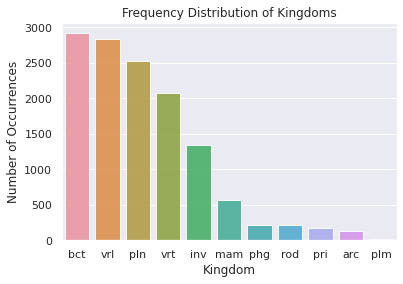

[22.41, 21.73, 19.37, 15.95, 10.33, 4.39, 1.69, 1.65, 1.38, 0.97, 0.14]


In [10]:
carrier_count = data['Kingdom'].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of Kingdoms')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Kingdom', fontsize=12)
plt.show()
print([np.round(class_/data.shape[0]*100, 2) for class_ in list(data['Kingdom'].value_counts())])

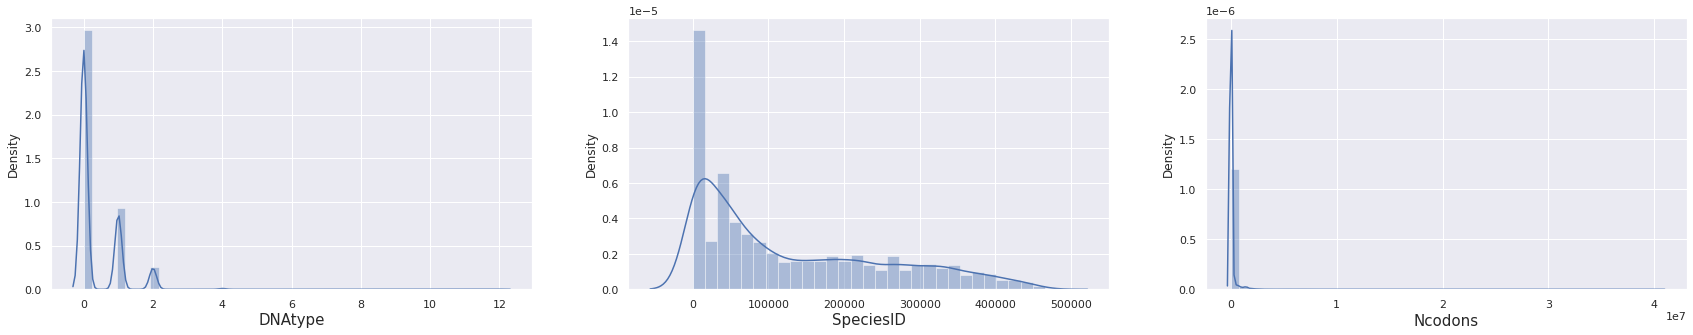

In [11]:
plt.figure(figsize = (50, 5))
plotnumber = 1
for column in data:
    if plotnumber <= 3 and column!='Kingdom':
        ax = plt.subplot(1, 5, plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column, fontsize = 15)
        plotnumber += 1
    elif plotnumber > 4:
        break
    
plt.show()

#### Κλάσεις και κωδικοποίηση των ετικετών τους
Απαριθμούμε τις ετικέτες κάθε μίας από τις 11 κλάσεις ξεκινώντας από το 0.

In [12]:
# βρίσκουμε τις μοναδικές ετικέτες
classes = np.unique(data['Kingdom'])
print("Our Classes are:\n", classes)
class_mapping = {label:idx for idx,label in enumerate(np.unique(data['Kingdom']))}
print("\nThe encoding we assume for each kingdom name is:\n")
mapping = pd.DataFrame.from_dict(class_mapping, orient='index', columns = ['Kigdom Encoding'])
mapping

Our Classes are:
 ['arc' 'bct' 'inv' 'mam' 'phg' 'plm' 'pln' 'pri' 'rod' 'vrl' 'vrt']

The encoding we assume for each kingdom name is:



,Kigdom Encoding
arc,0
bct,1
inv,2
mam,3
phg,4
plm,5
pln,6
pri,7
rod,8
vrl,9


In [13]:
# και κάνουμε την μετατροπή
data['Kingdom'] = data['Kingdom'].map(class_mapping)
#print data now that class labels are represented by integers (0 to 3)
data

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,9,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,9,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,9,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,9,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,9,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13021,7,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13022,7,1,9601,2067,mitochondrion Pongo pygmaeus abelii,0.01258,0.03193,0.01984,0.00629,0.01451,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13023,7,1,9602,1686,mitochondrion Pongo pygmaeus pygmaeus,0.01423,0.03321,0.01661,0.00356,0.01127,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13024,7,0,9606,40662582,Homo sapiens,0.01757,0.02028,0.00767,0.01293,0.01319,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


Πετάμε τις κολώνες με αρίθμηση 2-5, οι οποίες δεν συνεισφέρουν στο πρόβλημα κατηγοριοποίησης, και εν τέλει κρατάμε μόνο τις ετικέτες και τις συχνότητες εμφάνισης κωδωνίων. Σημειώνεται ότι παρόλο που η παραπάνω διαδικασία **feature selection** συνιστά μια μορφή βελτιστοποίησης του μοντέλου, μπορούμε να προβούμε εξαρχής στη διαγραφή των προαναφερθέντων κολώνων (δεν συνεισφέρουν στο πρόβλημα κατηγοριοποίησης).

In [14]:
#keep DNAtypes = 0, 1, 2, 4
data = data[data['DNAtype'].isin([0, 1 , 2, 4])]

#Discard genome entries comprising less than 1000 codons (from the ‘Ncodons‘ column).
data = data[data['Ncodons'] >= 1000]

# Drop Columns 2 through 5
data = data.drop(columns = ['SpeciesID', 'Ncodons', 'SpeciesName'])

#otherwise keeps original index after drop
data.reset_index(inplace=True, drop=True)
data

,Kingdom,DNAtype,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,9,0,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,9,0,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,9,0,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,9,0,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,9,0,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13006,7,0,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13007,7,1,0.01258,0.03193,0.01984,0.00629,0.01451,0.05322,0.07644,0.01258,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13008,7,1,0.01423,0.03321,0.01661,0.00356,0.01127,0.05042,0.09609,0.01068,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13009,7,0,0.01757,0.02028,0.00767,0.01293,0.01319,0.01959,0.00715,0.03964,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


Εν τέλει, κρατάμε 13011 δείγματα από τα 13026 (χωρίς τα NaN) και από τα 13028 που είχε αρχικά το dataset.

#### Αριθμητικά και κατηγορικά χαρακτηριστικά

Από τα χαρακτηριστικά που έχουμε κρατήσει το DNAtype είναι **μη-διατεταγμένο κατηγορικό**. 
Θα το μετατρέψουμε σε 4 binary χαρακτηριστικά (όσα και οι διαφορετικές τιμές) από τα οποία μόνο ένα είναι ενεργό κάθε φορά με χρήση της `get_dummies` συνάρτησης της pandas.


Σημείωση: Ελέγχουμε το variance του χαρακτηριστικού αυτού (σε σύγκριση με τα υπόλοιπα - που είναι αριθμητικά) και είναι πολύ μεγάλο, δεν ...
#TODO

In [15]:
data = pd.get_dummies(data, columns=['DNAtype'])
data

,Kingdom,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,...,GAC,GAA,GAG,UAA,UAG,UGA,DNAtype_0,DNAtype_1,DNAtype_2,DNAtype_4
0,9,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,...,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000,1,0,0,0
1,9,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,...,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000,1,0,0,0
2,9,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,...,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144,1,0,0,0
3,9,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,...,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000,1,0,0,0
4,9,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,...,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13006,7,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,0.01459,...,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638,1,0,0,0
13007,7,0.01258,0.03193,0.01984,0.00629,0.01451,0.05322,0.07644,0.01258,0.03096,...,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887,0,1,0,0
13008,7,0.01423,0.03321,0.01661,0.00356,0.01127,0.05042,0.09609,0.01068,0.02728,...,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017,0,1,0,0
13009,7,0.01757,0.02028,0.00767,0.01293,0.01319,0.01959,0.00715,0.03964,0.01600,...,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156,1,0,0,0


Στην συνέχεια ξεχωρίσουμε το σύνολο δεδομένων σε δύο σύνολα των features και labels αντίστοιχα, τα μετατρέψουμε σε numpy.arrays και ακολούθως προβαίνουμε στον **διαχωρισμό του συνόλου δεδομένων** σε σύνολο εκπαίδευσης (**train set**) και σύνολο (**test set**) με 20% των δειγμάτων στο test set (επιλέγουμε τον χωρισμό αυτό για να πάρουμε ικανοποιητικά μεγάλο training set ειδικά για τις κλάσεις με πολύ μικρό αριθμό δειγμάτων - είναι γνωστός αποδεκτός χωρισμός). 

In [14]:
#save processed data to file in order to use in other notebooks
#multiple notebooks were used in order to speed up the process 
#and be easier to read (because of the optuna outputs)
data.to_csv("data.csv", index = False)

In [16]:
##############################################
# labels of each sample are in the 1rst column
labels_df = data.iloc[:, 0]
features_df = data.iloc[:, 1:]
"""
Γνωρίζουμε ότι το csv μας περιέχουν μόνο αριθμητικά δεδομένα οπότε καλώντας τη μέθοδο .values τα δεδομένα μετατρέπονται αυτόματα σε πίνακα numpy αντί για data_frame.
"""
# convert to numpy arrays
features = features_df.values
labels = labels_df.values

###################################
print("data table", features.shape)
print("feature table", labels.shape)


data table (13011, 68)
feature table (13011,)


In [17]:
###################################
# Train - Test split 80/20 ########
###################################

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, stratify=labels)
#stratified split: διαχωρίζουμε με τέτοιο τρόπο τα δεδομένα ώστε να διατηρηθεί ίδιος ο αριθμός των διαφορετικών ψηφίων σε κάθε set

# Convert to float
X_train = X_train.astype('float')
X_test = X_test.astype('float')

#convert to int
y_test = y_test.astype('int')
y_train = y_train.astype('int')

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print(f"Trainset size is {len(X_train)/len(data)*100:.3f} % of the initial dataset, which is almost 80%.")


X_train shape:  (10408, 68)
X_test shape:  (2603, 68)
Trainset size is 79.994 % of the initial dataset, which is almost 80%.


#### Ισορροπημένο ή μη dataset
Προφανώς το dataset που έχουμε **δεν είναι ισορροπημένο**.

In [18]:
print(f"Training set has {len(y_train)} samples in total and it contains:")
for class_ in classes:
    print(f"* {np.sum(y_train == class_mapping[class_])} samples of class {class_}")
print("------------------------------------------------")
for class_ in classes:
    print(f"{class_} consists {np.sum(y_train == class_mapping[class_])/len(y_train)*100:.3f}% of the train set")

Training set has 10408 samples in total and it contains:
* 101 samples of class arc
* 2334 samples of class bct
* 1070 samples of class inv
* 458 samples of class mam
* 176 samples of class phg
* 14 samples of class plm
* 2013 samples of class pln
* 144 samples of class pri
* 172 samples of class rod
* 2265 samples of class vrl
* 1661 samples of class vrt
------------------------------------------------
arc consists 0.970% of the train set
bct consists 22.425% of the train set
inv consists 10.281% of the train set
mam consists 4.400% of the train set
phg consists 1.691% of the train set
plm consists 0.135% of the train set
pln consists 19.341% of the train set
pri consists 1.384% of the train set
rod consists 1.653% of the train set
vrl consists 21.762% of the train set
vrt consists 15.959% of the train set


Εκτυπώνουμε και τα δείγματα ανά κλάση στο αρχικό dataset και στο test set για πληρότερη εικόνα (θα μας χρειαστεί αργότερα όταν υπολογίζουμε την επίδοση στο test set).

In [19]:
print(f"Dataset has {len(features)} samples in total and it contains:")
for class_ in classes:
    print(f"* {np.sum(labels == class_mapping[class_])} samples of class {class_}")
print("------------------------------------------------")
for class_ in classes:
    print(f"{class_} consists {np.sum(labels == class_mapping[class_])/len(labels)*100:.3f}% of the dataset")

Dataset has 13011 samples in total and it contains:
* 126 samples of class arc
* 2918 samples of class bct
* 1337 samples of class inv
* 572 samples of class mam
* 220 samples of class phg
* 18 samples of class plm
* 2517 samples of class pln
* 180 samples of class pri
* 215 samples of class rod
* 2831 samples of class vrl
* 2077 samples of class vrt
------------------------------------------------
arc consists 0.968% of the dataset
bct consists 22.427% of the dataset
inv consists 10.276% of the dataset
mam consists 4.396% of the dataset
phg consists 1.691% of the dataset
plm consists 0.138% of the dataset
pln consists 19.345% of the dataset
pri consists 1.383% of the dataset
rod consists 1.652% of the dataset
vrl consists 21.759% of the dataset
vrt consists 15.963% of the dataset


In [110]:
print(f"Dataset has {len(features)} samples in total and it contains:")
for class_ in classes:
    print(f"* {np.sum(y_test == class_mapping[class_])} samples of class {class_}")
print("------------------------------------------------")
for class_ in classes:
    print(f"{class_} consists {np.sum(labels == class_mapping[class_])/len(labels)*100:.3f}% of the dataset")

Dataset has 13011 samples in total and it contains:
* 25 samples of class arc
* 584 samples of class bct
* 267 samples of class inv
* 114 samples of class mam
* 44 samples of class phg
* 4 samples of class plm
* 504 samples of class pln
* 36 samples of class pri
* 43 samples of class rod
* 566 samples of class vrl
* 416 samples of class vrt
------------------------------------------------
arc consists 0.968% of the dataset
bct consists 22.427% of the dataset
inv consists 10.276% of the dataset
mam consists 4.396% of the dataset
phg consists 1.691% of the dataset
plm consists 0.138% of the dataset
pln consists 19.345% of the dataset
pri consists 1.383% of the dataset
rod consists 1.652% of the dataset
vrl consists 21.759% of the dataset
vrt consists 15.963% of the dataset


## Ταξινόμηση
---

#### Μετρικές
Στο πρόβλημά μας έχουμε 11 κλάσεις : multiclass classificasion πρόβλημα. Η accuracy χρησιμοποιείται όταν μας ενδιαφέρουν περισσότερο να κατηγοριοποιούμε όσο το δυνατόν περισσότερα δείγματα σωστά χωρίς να μας ενδιαφέρουν τα "false negatives" (ως τι γίνονται misclassified τα δείγματα όπου έχουμε mispredictions). Αυτή είναι και η περίπτωση στο πρόβλημά μας καθώς μας ενδιαφέρει είναι το σύστημα μας να κατατάσσει ορθά τους οργανισμούς - δείγματα στο ζωικό βασίλειο που ανήκουν, όμως το dataset που μας δίνεται είναι highly imbalanced. Για αυτό ως βασική μετρική αξιολόγησης του εν λόγω προβλήματος χρησιμοποιούμε το **F1-score (macro)**, καθώς λαμβάνει υπόψη την κατανομή των δεγμάτων. Αναλυτικότερα, η ακρίβεια αντιμετωπίζει όλες οι περιπτώσεις το ίδιο (ανεξαρτήτως τάξεως) και συνήθως ευνοεί την πλειοψηφική τάξη. Αυτό μπορεί να είναι ένα προνόμιο εάν μας ενδιαφέρει να έχουμε καλή πρόβλεψη και για τις υποεκπροσωπούμενες τάξεις ή ένα μειονέκτημα αν μας ενδιαφέρει περισσότερο καλή πρόβλεψη για ολόκληρο το σύνολο δεδομένων. Αν μας ενδιαφέρει να επιτύχουμε καλές προβλέψεις και για σπάνιες κατηγορίες, οι πληροφορίες f1 macro score εγγυώνται τον εντοπισμό πιθανών προγνωστικών προβλημάτων και για τους υποεκπροσωπούμενες τάξεις, καθώς το f1 macro score δεν είναι τόσο ευαίσθητο στην ανισόρροπη κατανομή των κλάσεων και δίνει μεγαλύτερη βαρύτητα στις περιπτώσεις που προέρχονται από μειονοτικές τάξεις.  

#### Σχήμα CV
Ως σχήμα CV επιλέγουμε **n = 5 folds**, καθώς έχουμε ένα τεράστιο αριθμό δειγμάτων και η επιλογή μεγαλύτερου n θα επιβράδυνε κατά πολύ την διαδικασία της εκπαίδευσης. Μπορούμε, λοιπόν, να φανταστούμε ότι κάθε φορά το train set διασπάται σε 5 ισομέρη τμήματα, εκ των οποίων το πρώτο αποτελεί το σύνολο εκπαίδευσης και το δεύτερο το σύνολο επικύρωσης των υπερπαραμέτρων (validation dataset).


### Ταξινομητές

Στην περίπτωση του Kaggle dataset θα δουλέψουμε με δύο ταξινομητές

- Mylti-Layer Perceptron (MLP), και
- Support Vector Machines (SVM).

Αρχικά θα δούμε πως συμπεριφέρονται οι ταξινομητές χωρίς καμία βελτιστοποίηση (out-of-the-box) και με όλες τις παραμέτρους σε **default τιμές**. Εκπαιδεύουμε όλους τους εκτιμητές και υπολογίζουμε την επίδοσή τους στο test set ως προς το accuracy.

In [22]:
#in order to utilize GPU (to reduce train time)
# import cuml
# from cuml.svm import SVC

#dictionary of all estimators we want to test
estimators = {    
    "DummyClassifier\n(stratified)": DummyClassifier(strategy="stratified"),
    "SVC" : SVC(), 
    "MLP": MLPClassifier()
}

accuracies = {}
f1_scores = {}


# Evaluate default models
for model_name, model in estimators.items():
  model.fit(X_train, y_train) # train model (on train set obviously)
  predictions = model.predict(X_test)  #make predictions on test set
  #ο υπολογισμός του accuracy γίνεται με την μέθοδο του αντικειμένου του classifier
  #δεν χρειάζεται να καλέσουμε την predict καθώς την καλεί η score εσωτερικά, χρειάζεται όμως για τον υπολογισμό του f1 οπότε το αφήνουμε
  acc = model.score(X_test, y_test)
  f1 = sklearn.metrics.f1_score(y_test, predictions, average = 'macro')
  accuracies[model_name] = round(acc*100, 3)
  f1_scores[model_name]  = round(f1*100, 3)

#sort so we print them in order of decreasing accuracy
sorted_accuracies = dict(sorted(accuracies.items(), key=lambda x:x[1], reverse=True))

In [24]:
# Show results (so we can easily put them in markdown)
start = "\033[1m"
end = "\033[0;0m"
print("------------------------------------------------------------------")
print(f"| {start}Estimator{end}                       | {start}Accuracy (%) {end}| {start}F1 Metric (%){end} |")
print("| :-------------------------:     | :----------: | :-----------: |")
for est in sorted_accuracies.keys():
    est_name = est.replace("\n", "")
    print(f"| {est_name: <30}  |       {str(sorted_accuracies[est]):<6} |        {str(f1_scores[est]):<6} |")
print("------------------------------------------------------------------")

------------------------------------------------------------------
| Estimator                       | Accuracy (%) | F1 Metric (%) |
| :-------------------------:     | :----------: | :-----------: |
| MLP                             |       88.821 |        64.796 |
| SVC                             |       69.458 |        30.954 |
| DummyClassifier(stratified)     |       18.786 |        8.764  |
------------------------------------------------------------------


Στον παρακάτω πίνακα φαίνονται οι επιδόσεις του κάθε ταξινομητή με βάση τις μετρικές accuracy και F1 (με φθίνουσα σειρά F1).

------------------------------------------------------------------
| Estimator                       | Accuracy (%) | F1 Metric (%) |
| :-------------------------:     | :----------: | :-----------: |
| MLP                             |       88.821 |        64.796 |
| SVC                             |       69.458 |        30.954 |
| DummyClassifier(stratified)     |       18.786 |        8.764  |
------------------------------------------------------------------

Καταρχάς, και οι δύο ταξινομητές, ο SVM και το MLP δίκτυο, επιτυγχάνουν ικανοποιητικά ποσοστά ευστοχίας στο πρόβλημα κατηγοριοποίησης  συγκριτικά με την baseline επίδοση του dummy classifier με την out-of-the-box προσέγγιση. Το accuracy που επιτυγχάνουν είναι σαφώς μεγαλύτερο από το f1 macro score και αυτό οφείλεται στο ότι υπάρχουν κλάσεις με πολύ λίγα δείγματα (π.χ. arc, plm, pri, rod  αποτελούν περίπου 1% του dataset, όπως θα δούμε και παρακάτω η απόδοση στο plm που αποτελεί μόλις 0.154% του train set θα παραμείνει χαμηλή και μετά την βελτιστοποίηση). Οι ταξινομητές που δοκιμάζουμε βασίζονται σε τελείως διαφορετικές στρατηγικές μάθησης. Στο Νευρωνικό Δίκτυο τα βάρη του δικτύου (οι fitting παράμετροι που προσαρμόζονται κατά την διάρκεια του training) προσαρμόζονται έτσι ώστε το άθροισμα του τετραγώνου του λάθους μεταξύ της εξόδου του δικτύου και της πραγματικής τιμή να ελαχιστοποιείται. Αντίθετα, εκπαίδευση ενός SVM σημαίνει ρητό καθοριμσό των ορίων απόφασης απευθεία από τα δεδομένα εκπαίδευσης. Σκοπός είναι η ελαχιστοποίηση της aggregate απόστασης μεταξύ των μεγίστου "margin" hyperplane και των support vectors. Και οι δύο ταξινομητές μπορούν να απεικονίσουν τα δεδομένα εισόδου σε χώρους μεγαλύτερης διάστασης, ώστε να είναι σε θέση να σχηματίσουν τις επιφάνειες διαχωρισμού του προβλήματος ακόμα και αν αυτές είναι μη γραμμικές. Το Νευρωνικό Δίκτυο με χρήση μη γραμμικών συναρτήσεων ενεργοποίησης. Όμως καθώς ο ταξινομητής SVM το επιτυγχάνει αυτό χρησιμοποιώντας κατάλληλες συναρτήσεις πυρήνα και η default συνάρτηση πυρήνα είναι η "linear" (χρήσιμη σε γραμμικά διαχωρίσιμα πρόβληματα) είναι λογικό ο SVM να έχει τόσο χαμηλότερη επίδοση από τον MLP Classifier (μόνο 32%).



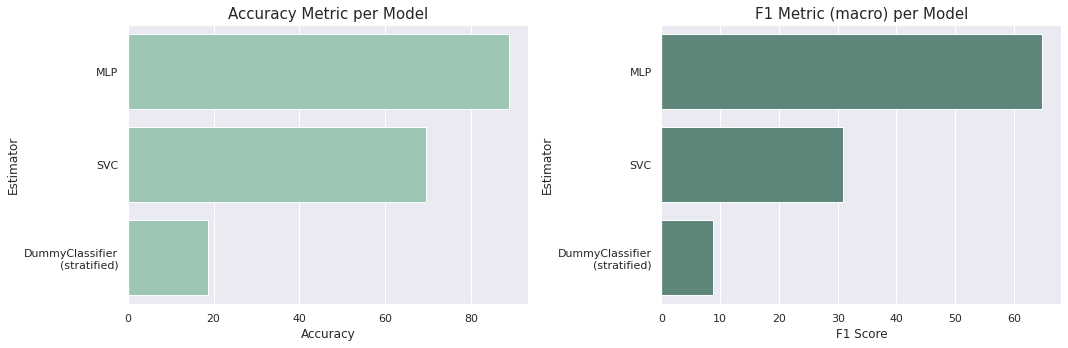

In [25]:
# Create Bar Plots for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
model_labels = list(estimators.keys())
data_df = pd.DataFrame({"Accuracy":list(accuracies.values()), "Estimator":model_labels})
sns.barplot(x="Accuracy",
            y="Estimator",
            data=data_df,
            order= data_df.sort_values("Accuracy", ascending=False).Estimator,
            color=colors[1],
            ax = ax1)

data_df = pd.DataFrame({"F1 Score":list(f1_scores.values()), "Estimator":model_labels})
sns.barplot(x="F1 Score",
            y="Estimator",
            data=data_df,
            order= data_df.sort_values("F1 Score", ascending=False).Estimator,
            color = colors[0],
            ax= ax2)

ax1.set_title("Accuracy Metric per Model",  fontsize=15)

ax2.set_title("F1 Metric (macro) per Model",  fontsize=15)
plt.tight_layout()
plt.show()

## Βελτιστοποίηση
---

Στην συνέχεια για να βελτιώσουμε τα μοντέλα μας χρησιμοποιούμε την βιβλιοθήκη Optuna. Eπιλέγοντας κατάλληλες υπερπαραμέτρους στο σύστημα μηχανικής μάθησης μας με τις δυνατότητες που παρέχει η βιβλιοθήκη Optuna θα προσπαθήσουμε να βελτιστοποιήσουμε τους 2 παραπάνω ταξινομητές (MLP και SVM). Πιο συγκεκριμένα, θα βρούμε τις βέλτιστες υπερπαραμέτρους των Transformers που αφορούν στο preprocessing της διαδικασίας μάθησης: θα χρησιμοποιήσουμε έναν **Variance Thresholder**, έναν **Standard Scaler**, έναν **Random OverSampler** και την **PCA** ως τεχνική μείωσης διαστατικότητας του προβλήματος. Έχουμε 11 κλάσεις και το dataset είναι imbalanced όπως προαναφέρθηκε (π.χ. arc, plm, pri, rod  αποτελούν περίπου 1% του dataset, όπως θα δούμε και παρακάτω η απόδοση στο plm που αποτελεί μόλις 0.154% του train set). Με το random oversampling εξισσοροπούμε το train set για να μειώσουμε το bias του ταξινομητή (μεγαλύτερες κλάσεις) και να αυξήσουμε την απόδοση. Υπολογίζοντας τις τιμές variance για κάθε feature παρατηρούμε ότι γενικά είναι πολύ μικρές. Μεγαλύτερε τιμές variance έχουν τα κατηγορικά χαρακτηριστικά στα οποία έχει και νόημα να εφαρμόσουμε variance threshold. Θα αρκεστούμε να προσδιορίσουμε μέγιστο όριο variance threshold μικρότερο από το variance των κατηγορικών χαρακτηριστικών (DNAType - sparse αναπαράσταση). Προσδιορίσουμε τις βέλτιστες υπερπαραμέτρους που αφορούν στον ίδιο τον **classifier** μέσω των μεθόδων της βιβλιοθήκης Optuna (βλέπε παρακάτω). Τα στάδια αυτά συνδυάζονται σε ένα **pipeline**. Με χρήση Optuna, προσδιορίζουμε τον βέλτιστο συνδυασμό υπερπαραμέτρων που μεγιστοποιεί την ευστοχία, εκπαιδεύοντας κάθε φορά και αξιολογώντας το μοντέλο χρησιμοποιώντας **5-fold cross-validation**.

In [ ]:
###########################################################################
# Print Variance of each feature to decide possible values for thresholding
###########################################################################

train_variance = X_train.var(axis=0)
print("\n".join(list(np.array(sorted(train_variance)).astype("str"))))

7.656495526116279e-07
3.312944850926761e-06
2.2779025340074714e-05
3.7630767972897193e-05
3.7992796244641034e-05
3.847936432045666e-05
3.900268763475182e-05
4.035171867057641e-05
4.051488461603476e-05
4.115932501882863e-05
4.271321903354656e-05
4.340266652137397e-05
4.357516301951795e-05
4.5369123327216236e-05
4.649040199988118e-05
4.6822097112727534e-05
4.993030097516244e-05
5.337820618662856e-05
5.7220261556429053e-05
6.703325927149656e-05
6.815980703178e-05
6.933701317922491e-05
7.341829025716782e-05
7.873301277161559e-05
8.035980282659586e-05
8.044556970293056e-05
8.172825413043917e-05
8.351035405887139e-05
8.558005903011026e-05
8.610759564755687e-05
9.035771260729865e-05
9.142385255440803e-05
9.789359498101933e-05
9.872904201111148e-05
0.0001016448909825978
0.00010644300784364998
0.00010934269199525614
0.00011090936614773216
0.00011401103943263533
0.00011454922930676993
0.0001253466618177567
0.00013442973511606487
0.00013825157723960674
0.00013973403557845023
0.0001559641216898537

In [ ]:
pd.DataFrame(features_df.var())

,0
UUU,0.000307
UUC,0.000134
UUA,0.000426
UUG,0.000086
CUU,0.000112
...,...
UGA,0.000107
DNAtype_0,0.205034
DNAtype_1,0.173180
DNAtype_2,0.058787


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Kingdom,13011.0,5.580586,3.532938,0.0,2.000000,6.00000,9.00000,10.00000
UUU,13011.0,0.024777,0.017535,0.0,0.013910,0.02174,0.03128,0.21730
UUC,13011.0,0.023451,0.011596,0.0,0.015400,0.02192,0.02922,0.09169
UUA,13011.0,0.020595,0.020647,0.0,0.005605,0.01525,0.02945,0.15133
UUG,13011.0,0.014102,0.009277,0.0,0.007100,0.01336,0.01981,0.10119
...,...,...,...,...,...,...,...,...
UGA,13011.0,0.006182,0.010349,0.0,0.000410,0.00113,0.00289,0.10670
DNAtype_0,13011.0,0.712090,0.452806,0.0,0.000000,1.00000,1.00000,1.00000
DNAtype_1,13011.0,0.222811,0.416149,0.0,0.000000,0.00000,0.00000,1.00000
DNAtype_2,13011.0,0.062716,0.242461,0.0,0.000000,0.00000,0.00000,1.00000


## Βελτιστοποίηση του Ταξινομητή Multi-Layered Perceptron (MLP)
---

Προσδιορίζουμε τις παρακάτω υπερπαραμέτρους.
Οι υπερπαράμετροι που αφορούν:
* το preprocessing είναι:
    * **vthreshold**: το κατώφλι τιμής διασποράς του Variance Thresholder. Το εύρος τιμών του ανήκει στο διάστημα [$10^{-7}$, $10^{-4}$] και επιλέγεται με βάση τις διασπορές των κολώνων του dataset. Συγκεκριμένα παρατηρούμε ότι στην περίπτωσή μας 0.000107 είναι το μεγαλύτερο variance αριθμητικού χαρακτηριστικού (στα αριθμητικά χατρακτηριστικά έχει νόημα να εφαρμοστεί variance threshold).
    * **n_components**: το πλήθος των συνιστωσών του PCA. Το εύρος προσδιορίζουμε από 2 έσω 67, λαμβάνοντας υπόψη ότι η αρχική διαστατικότητα του προβλήματος είναι 68.
* τον classifier είναι:
    * **n_layers**: ο αριθμός των επιπέδων του Νευρωνικού Δικτύου
    * **n_units**: o αριθμός των νευρώνων κάθε επιπέδου
    * **activation**: η χρησιμοποιούμενη μη γραμμική συνάρτηση ενεργοποίησης. Αναζητάμε μεταξύ των ReLU, tanh και logistic.
    * **learning rate**: o ρυθμός μάθησης. Το εύρος τιμών του ανήκει στο διάστημα [$10^{-5}$, $10^{-2}$]
    * **optimizer**: ο χρησιμοποιούμενος βελτιστοποιητής, ανάμεσα στους Adam και SGD.
    * **max_iter**: ο μέγιστος αριθμός επαναλήψεων κατά την εκπαίδευση του Νευρωνικού.

Σε κάθε περίπτωση, εφαρμόζουμε τεχνικές **Early Stopping**, προκειμένου να αποφύγουμε φαινόμενα *overfitting* κατά την εκπαίδευση του Νευρωνικού που θα μείωναν την επίδοση στο test set. 
Οι βέλτιστες τιμές υπερπαραμέτρων αναζητούνται με χρήση Optuna αρχικά για 15 tasks. Θα δοκιμάσουμε και με περισσότερα (βλέπε παρακάτω).

In [ ]:
# Main Hyperparameter Optimization Function
def objective(trial, X_train, y_train):
    
    ## Hyperparameters for variance thresholding
    vthreshold = trial.suggest_loguniform('vthres', 1e-7, 1e-4) 
    
    ## Hyperparameters for Principal Component Analysis
    n_components = trial.suggest_int('pca_n', 2,69,3)
    
    #Hyperparameters for sampling
    sampling_strategy = ['majority', 'not minority', 'not majority', 'all']
    
    # Hyperparameters of MLP Classifier
    n_layers = trial.suggest_int('n_layers', 3, 7)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 10, 500, 30))

    activation = trial.suggest_categorical('activation', 
                                           ["relu","tanh", 
                                            "logistic"])

    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-5, 1e-2)
    
    optimizer = trial.suggest_categorical('optimizer', ['sgd', 'adam'])
    
    #learning_rate = trial.suggest_categorical('learning_rate', ['adaptive', 'constant'])
    
    max_iter = trial.suggest_int('max_iter', 100, 800, 100)
    
    # Define Classifier
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers), solver = optimizer,
                        activation = activation, max_iter = max_iter, 
                        learning_rate_init = learning_rate_init, early_stopping = True, batch_size = 256, learning_rate= 'adaptive')#learning_rate)
    
    # initialize transformers with optuna hyperparameters
    selector= VarianceThreshold(threshold=vthreshold)
    scaler = StandardScaler()
    ros = RandomOverSampler()#(sampling_strategy = sampling_strategy )
    pca = PCA(n_components=n_components)

    # Define Pipe
    pipe = Pipeline(steps=[('selector', selector),
                        ('scaler', scaler), 
                        ('sampler', ros), 
                        ('pca', pca), 
                        ('estimator', clf)], memory = 'tmp')

    # Train with Cross-Validation
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')
    print(scores)
    return np.mean(scores)
                                           

In [ ]:
study1 = optuna.create_study(direction='maximize', study_name='MLP_study', storage='sqlite:///example.db', load_if_exists=True)
study1.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=7, n_jobs=-1)

[I 2022-11-23 10:24:53,676] A new study created in RDB with name: MLP_study

[I 2022-11-23 11:37:38,141] Trial 3 finished with value: 0.12646849188628945 and parameters: {'vthres': 1.1231368926907824e-05, 'pca_n': 38, 'n_layers': 3, 'n_units_0': 490, 'n_units_1': 190, 'n_units_2': 160, 'activation': 'logistic', 'learning_rate_init': 0.002925606705683421, 'optimizer': 'sgd', 'max_iter': 600}. Best is trial 3 with value: 0.12646849188628945.
[0.13117935 0.16417095 0.11156774 0.10560904 0.11981538]
[I 2022-11-23 12:37:32,858] Trial 2 finished with value: 0.7394750251573683 and parameters: {'vthres': 4.5276763005032236e-07, 'pca_n': 20, 'n_layers': 7, 'n_units_0': 100, 'n_units_1': 70, 'n_units_2': 490, 'n_units_3': 490, 'n_units_4': 430, 'n_units_5': 70, 'n_units_6': 10, 'activation': 'relu', 'learning_rate_init': 7.640981314254155e-05, 'optimizer': 'adam', 'max_iter': 400}. Best is trial 2 with value: 0.7394750251573683.
[0.72694191 0.78807348 0.7378457  0.73757698 0.70693705]
[I 2022-11

In [ ]:
print("## Best Model ##")
print('F1 Score: ',np.round(100*study1.best_value,3),'%')
print('Parameters:')
print(study1.best_params)


## Best Model ##

F1 Score:  79.699 %

Parameters:

{'activation': 'relu', 'learning_rate_init': 0.0030167784255914756, 'max_iter': 800, 'n_layers': 7, 'n_units_0': 280, 'n_units_1': 310, 'n_units_2': 70, 'n_units_3': 400, 'n_units_4': 40, 'n_units_5': 220, 'n_units_6': 70, 'optimizer': 'adam', 'pca_n': 65, 'vthres': 6.195064054940584e-06}



Παρακάτω φαίνονται το **γράφημα ιστορικού** της διαδικασίας βελτιστοποίησης για τα 7 tasks, το **slice plot** για όλες τις υπερπαραμέτρους και το γράφημα με τις **hyperparameter importances**. Αρχικά δοκιμάζουμε μικρό πλήθος trials και εξετάζουμε ποιά είναι τα χαρακτηριστικά που συμβάλουν περισσότερο στην βελτίωση της απόδοσης ώστε να μπορούμε να αυξήσουμε το πλήθος των trials χωρίς να έχουμε πολύ μεγάλο run time (βλέπουμε ότι η αύξηση είναι υποσχόμενη για την αύξηση της επίδοσης - δεν έχει συγκλίνει η διαδικσία εύρεσης). Για τα χαρακτηριστικά που δεν έχουν μεγάλη επίδραση στην επίδοση του μοντέλου διαλέγουμε μία τιμή που δεν επιβαρύνει το μοντέλο. 
Πιο συγκεκριμένα (με σειρά importance σύμφωνα με το διάγραμμα):
* activation: Η logistic δεν έχει καθόλου καλά αποτελέσματα οπότε την αφαιρούμε από τις δοκιμές μας.
* n_units_0: Καλύτερα αποτελέσματα έχουμε για μικρότερες του 300 τιμές οπότε δοκιμάζουμε τιμές από 80 μέχρι 300 με λίγο μικρότερο βήμα (20).
* vthres: Είναι πολύ σημαντικό,οπότε δεν το αλλάζουμε.
* optimizer:  Ο sgd δεν τα πηγαίνει καλά οπότε τον αφαιρούμε από τις δοκιμές μας.
* learning_rate_init: Δοκιμάζουμε μεγαλύτερο εύρος τιμών.
* n_layers: Αυξάνουμε ελαφρώς το πλήθος εφόσον για 7 (που είναι το μέγιστο που δοκιμάζουμε) έχουμε τα καλύτερα αποτελέσματα.
* n_units_2: Δοκιμάζουμε < 200 (τότε έχουμε καλύτερη επίδοση και είναι πιο γρήγορο το μοντέλο).
* n_units_1: Δοκιμάζουμε τιμές 300 έως 400.

Για τα υπόλοιπα layes δεν χρειαζόμαστε τόσα πολλά (επειδή είναι λιγότερο σημαντικά) οπότε επιλέγουμε λιγότερα (και λίγες δοκιμές).
* pca_n: Δεν χρειάζεται να έχουμε πολλά components εφόσον επιβαρύνουν την εκπαίδευση χωρίς να προσφέρουν σημαντική πληροφορία για καλύτερα αποτελέσματα. 
* max_iter: Διαλέγουμε μικρότερο πλήθος εφόσον οι επαναλήψεις αχρείαστα από ότι βλέπουμε επιβαρύνουν χρονικά την εκπαίδευση του μοντέλου.

In [ ]:
optuna.visualization.plot_param_importances(study1)

In [ ]:
optuna.visualization.plot_optimization_history(study1)

In [ ]:
optuna.visualization.plot_slice(study1)

optimazation with "tailored" parameter seach fields:

In [ ]:
"""
Best model so far:
{'activation': 'relu', 'learning_rate_init': 0.0030167784255914756, 
'max_iter': 800, 'n_layers': 7, 'n_units_0': 280, 'n_units_1': 310, 'n_units_2': 70, 
'n_units_3': 400, 'n_units_4': 40, 'n_units_5': 220, 'n_units_6': 70, 
'optimizer': 'adam', 'pca_n': 65, 'vthres': 6.195064054940584e-06}
"""
#from optuna.exceptions import StopStudy
# Main Hyperparameter Optimization Function
def objective(trial, X_train, y_train):
    
    ## Hyperparameters for variance thresholding
    vthreshold = trial.suggest_loguniform('vthres', 1e-7, 1e-4) 
    
    ## Hyperparameters for Principal Component Analysis
    n_components = trial.suggest_int('pca_n', 20,60,20) 
    
    # Hyperparameters of MLP Classifier
    n_layers = trial.suggest_int('n_layers',7 , 14, 3)
    layers = []
    layers.append(trial.suggest_int('n_units_0', 200, 300, 20))
    layers.append(trial.suggest_int('n_units_1', 300, 400, 20))
    for i in range(2, n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 50, 200, 50))  

    activation = trial.suggest_categorical('activation', 
                                           ["relu","tanh"])

    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-6, 1e-1)
    
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    
    learning_rate = trial.suggest_categorical('learning_rate', ['adaptive','constant'])
    #max_iter = trial.suggest_int('max_iter', 200, 250, 50)
    
    # Define Classifier
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers), solver = optimizer,
                        activation = activation, max_iter = 200, #max_iter, 
                        learning_rate_init = learning_rate_init, early_stopping = True, batch_size = 256, learning_rate = learning_rate)
    
    # initialize transformers with optuna hyperparameters
    selector= VarianceThreshold(threshold=vthreshold)
    scaler = StandardScaler()
    ros = RandomUnderSampler()#sampling_strategy = sampling_strategy )
    pca = PCA(n_components=n_components)

    # Define Pipe
    pipe = Pipeline(steps=[('selector', selector),
                        ('scaler', scaler), 
                        ('sampler', ros), 
                        ('pca', pca), 
                        ('estimator', clf)], memory = 'tmp')

    # Train with Cross-Validation
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')
    return np.mean(scores)                  


In [ ]:
study2_ = optuna.create_study(direction='maximize')#, study_name='MLP_study1_', storage='sqlite:///example.db', load_if_exists=True)
study2_.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=20, n_jobs=-1)#, callbacks=[callback])

[I 2022-11-25 22:47:19,444] A new study created in memory with name: no-name-820011d2-31c0-4fc2-83cd-b5cf77198acf
[I 2022-11-25 22:47:45,962] Trial 1 finished with value: 0.03263926073195091 and parameters: {'vthres': 2.3058150248439687e-07, 'pca_n': 20, 'n_layers': 10, 'n_units_0': 240, 'n_units_1': 340, 'n_units_2': 100, 'n_units_3': 50, 'n_units_4': 150, 'n_units_5': 100, 'n_units_6': 150, 'n_units_7': 200, 'n_units_8': 150, 'n_units_9': 100, 'activation': 'tanh', 'learning_rate_init': 2.822447348874639e-05, 'optimizer': 'sgd', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.03263926073195091.
[I 2022-11-25 22:47:48,042] Trial 2 finished with value: 0.022065147266795586 and parameters: {'vthres': 1.3930869880461447e-07, 'pca_n': 60, 'n_layers': 13, 'n_units_0': 240, 'n_units_1': 360, 'n_units_2': 200, 'n_units_3': 100, 'n_units_4': 200, 'n_units_5': 50, 'n_units_6': 100, 'n_units_7': 100, 'n_units_8': 100, 'n_units_9': 200, 'n_units_10': 100, 'n_units_11': 50, 'n_units_1

In [ ]:
print("## Best Model ##")
print('F1 Score: ',np.round(100*study2_.best_value,3),'%')
print('Parameters:')
print(study2_.best_params)

## Best Model ##
F1 Score:  40.36 %
Parameters:
{'vthres': 1.0588029006022547e-06, 'pca_n': 40, 'n_layers': 7, 'n_units_0': 200, 'n_units_1': 380, 'n_units_2': 150, 'n_units_3': 200, 'n_units_4': 150, 'n_units_5': 50, 'n_units_6': 150, 'activation': 'relu', 'learning_rate_init': 0.0019502708074435355, 'optimizer': 'adam', 'learning_rate': 'adaptive'}


In [ ]:
optuna.visualization.plot_optimization_history(study2_)

In [ ]:
optuna.visualization.plot_param_importances(study2_)

In [ ]:
optuna.visualization.plot_slice(study2_)

Στη συνέχεια, δημιουργούμε το συνολικό μοντέλο pipeline με ταξινομητή MLP σύμφωνα με τις βέλτιστες τιμές υπερπαραμέτρων που προσδιορίστηκαν από την άνωθι διαδικασία και αξιολογούμε τις επιδόσεις του πάνω στο test set.

In [ ]:
best_params = study2_.best_params
#This is equal to: 
#best_params = {'vthres': 1.0588029006022547e-06, 'pca_n': 40, 'n_layers': 7, 'n_units_0': 200, 'n_units_1': 380, 'n_units_2': 150, 'n_units_3': 200, 'n_units_4': 150, 'n_units_5': 50, 'n_units_6': 150, 'activation': 'relu', 'learning_rate_init': 0.0019502708074435355, 'optimizer': 'adam', 'learning_rate': 'adaptive'}
#(pls uncomment in need of rerunning the notebook without optimization process - it takes long!)

#-----------------------------------------------------#
#various results from running optimization with optuna - pls ignore! - just checking
#best_params =  {'vthres': 6.328499665682601e-07, 'pca_n': 60, 'n_layers': 7, 'n_units_0': 280, 'n_units_1': 100, 'n_units_2': 250, 'n_units_3': 150, 'n_units_4': 100, 'n_units_5': 100, 'n_units_6': 200, 'activation': 'tanh', 'learning_rate_init': 0.021838407944656066, 'optimizer': 'sgd', 'learning_rate': 'adaptive'}#93.623 %
#best_params = {'vthres': 6.328499665682601e-07, 'pca_n': 60, 'n_layers': 7, 'n_units_0': 280,'n_units_0': 200, 'n_units_1': 100, 'n_units_2': 250, 'n_units_3': 150, 'n_units_4': 100, 'n_units_5': 100, 'n_units_6': 200, 'activation': 'tanh', 'learning_rate_init': 0.021838407944656066, 'optimizer': 'sgd', 'learning_rate': 'adaptive'}#93.239 %
#best_params = {'vthres': 1.649507050185266e-07, 'pca_n': 20, 'n_layers': 13, 'n_units_0': 280, 'n_units_1': 400, 'n_units_2': 50, 'n_units_3': 50, 'n_units_4': 250, 'n_units_5': 50, 'n_units_6': 150, 'n_units_7': 250, 'n_units_8': 250, 'n_units_9': 100, 'n_units_10': 150, 'n_units_11': 150, 'n_units_12': 150, 'activation': 'tanh', 'learning_rate_init': 0.001332330577054705, 'optimizer': 'adam', 'learning_rate': 'adaptive'}
#best_params = {'vthres': 1.2216612598953075e-06, 'pca_n': 20, 'n_layers': 7, 'n_units_0': 260, 'n_units_1': 380, 'n_units_2': 150, 'n_units_3': 150, 'n_units_4': 200, 'n_units_5': 100, 'n_units_6': 100, 'activation': 'relu', 'learning_rate_init': 0.003478354255306883, 'optimizer': 'adam', 'learning_rate': 'constant'}
#best_params = {'vthres': 1.0588029006022547e-06, 'pca_n': 40, 'n_layers': 7, 'n_units_0': 200, 'n_units_1': 380, 'n_units_2': 150, 'n_units_3': 200, 'n_units_4': 150, 'n_units_5': 50, 'n_units_6': 150, 'activation': 'relu', 'learning_rate_init': 0.0019502708074435355, 'optimizer': 'adam', 'learning_rate': 'adaptive'}
#-----------------------------------------------------#

# Hyperparameters of Preprocessing Transformers
vthreshold = best_params['vthres']
n_components = best_params['pca_n']

# Hyperparameters of MLP Classifier
n_layers = best_params['n_layers']
layers = []
for i in range(n_layers):
    layers.append(best_params[f'n_units_{i}'])
#layers = [study1.best_params['n_units_0'],study1.best_params['n_units_1']]

activation = best_params['activation']
learning_rate = best_params['learning_rate']
learning_rate_init = best_params['learning_rate_init']
optimizer = best_params['optimizer']
#max_iter = study1.best_params['max_iter']

# Define Best Classifier
clf = MLPClassifier(hidden_layer_sizes=tuple(layers), solver = optimizer,
                    activation = activation, max_iter = 200,#max_iter, 
                    learning_rate_init = learning_rate_init, learning_rate = 'adaptive',#learning_rate, 
                    early_stopping = True)

# Define Best Transformers
selector = VarianceThreshold(threshold=vthreshold)
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA(n_components=n_components)

# Define Best Pipe
best_MLP_pipe = Pipeline(steps=[('selector', selector),
                    ('scaler', scaler), 
                    ('sampler', ros), 
                    ('pca', pca), 
                    ('estimator', clf)], memory = 'tmp')


In [ ]:
print('Best MLP Classifier Performance\n')
metrics1, train_time1, test_time1 = evaluate_best(best_MLP_pipe, X_train, X_test, y_train, y_test, 'macro avg')
print(f'F1_score (macro) = {100*metrics1["f1-score"]:.3f} %')
print(f'Train Time = {1000*train_time1:.3f} msec')
print(f'Evaluation Time = {1000*test_time1:.3f} msec\n')

Best MLP Classifier Performance

              precision    recall  f1-score   support

           0       0.79      0.82      0.81        28
           1       0.94      0.95      0.95       587
           2       0.90      0.85      0.88       272
           3       0.84      0.84      0.84       110
           4       0.74      0.91      0.81        43
           5       0.33      0.33      0.33         3
           6       0.94      0.93      0.94       478
           7       0.74      0.82      0.78        39
           8       0.70      0.79      0.74        33
           9       0.96      0.96      0.96       593
          10       0.97      0.96      0.97       417

    accuracy                           0.93      2603
   macro avg       0.81      0.83      0.82      2603
weighted avg       0.93      0.93      0.93      2603

F1_score (macro) = 81.900 %
Train Time = 104284.104 msec
Evaluation Time = 87.870 msec



Παρατηρούμε ότι από τα 17 trials ο αλγόριθμος optimization έχει συγκλίνει επομένως πιθανότατα δεν υπάρχει ανάγκη για περισσότερα αλλά δοκιμάζουμε να δοκιμάσουμε και περισσότερα (80) για να σιγουρευτούμε.

In [ ]:
study2_ = optuna.create_study(direction='maximize')#, study_name='MLP_study1_', storage='sqlite:///example.db', load_if_exists=True)
study2_.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=80, n_jobs=-1)#, callbacks=[callback])

[I 2022-11-25 23:41:27,920] A new study created in memory with name: no-name-6d78a711-8844-4c0d-b957-cf5685023644
[I 2022-11-25 23:41:45,981] Trial 2 finished with value: 0.03789193952930945 and parameters: {'vthres': 2.7955752927933118e-05, 'pca_n': 20, 'n_layers': 10, 'n_units_0': 260, 'n_units_1': 340, 'n_units_2': 50, 'n_units_3': 50, 'n_units_4': 100, 'n_units_5': 50, 'n_units_6': 50, 'n_units_7': 150, 'n_units_8': 50, 'n_units_9': 100, 'activation': 'tanh', 'learning_rate_init': 3.454218198390633e-05, 'optimizer': 'sgd', 'learning_rate': 'constant'}. Best is trial 2 with value: 0.03789193952930945.
[I 2022-11-25 23:41:53,743] Trial 1 finished with value: 0.018847739232392885 and parameters: {'vthres': 7.411486080044014e-06, 'pca_n': 60, 'n_layers': 13, 'n_units_0': 300, 'n_units_1': 360, 'n_units_2': 100, 'n_units_3': 100, 'n_units_4': 150, 'n_units_5': 50, 'n_units_6': 200, 'n_units_7': 50, 'n_units_8': 100, 'n_units_9': 50, 'n_units_10': 150, 'n_units_11': 200, 'n_units_12': 50

In [ ]:
optuna.visualization.plot_optimization_history(study2_)

In [ ]:
print("## Best Model ##")
print('F1 Score: ',np.round(100*study1_.best_value,3),'%')
print('Parameters:')
print(study1_.best_params)

## Best Model ##
F1 Score:  35.993 %
Parameters:
{'vthres': 1.4459307343420667e-07, 'pca_n': 40, 'n_layers': 7, 'n_units_0': 240, 'n_units_1': 340, 'n_units_2': 150, 'n_units_3': 100, 'n_units_4': 150, 'n_units_5': 100, 'n_units_6': 200, 'activation': 'tanh', 'learning_rate_init': 0.060147225516735306, 'optimizer': 'sgd', 'learning_rate': 'constant'}


Πράγματι ο αλγόριθμος στα 17 trials συγκλίνει και δεν μας χρειάζονται περισσότερα. Στην συνέχεια κάνουμε το optimization με RandomOverSampler μετά από κάποιες μικροαλλαγές για να μειώσουμε τους αχρείαστους ελέγχους με σκοπό να επιβεβαιώσουμε την θεώρησή μας ότι τα επιπλέον trials δεν μπορούν να αυξήσουν την απόδοση (και άρα δεν μας είναι χρήσιμα, ειδικά αν υπολογίσουμε την χρονική επιβάρυνση που επιφέρουν στην διαδικασία optimization).

Να σημειωθεί ότι η επίδοση εξαρτάται σε κάποιο βαθμό και από το πώς γίνεται το split. Για παράδειγμα με διαφορετικό split αρχικό έχουμε λίγο υψηλότερη επίδοση (προφανώς εδώ έτυχε, θα μπορούσε να είναι και χαμηλότερη). 

In [ ]:
#---------------------------------------------#
#best_params =  {'vthres': 6.328499665682601e-07, 'pca_n': 60, 'n_layers': 7, 'n_units_0': 280, 'n_units_1': 100, 'n_units_2': 250, 'n_units_3': 150, 'n_units_4': 100, 'n_units_5': 100, 'n_units_6': 200, 'activation': 'tanh', 'learning_rate_init': 0.021838407944656066, 'optimizer': 'sgd', 'learning_rate': 'adaptive'}
#93.623 %
#best_params = {'vthres': 6.328499665682601e-07, 'pca_n': 60, 'n_layers': 7, 'n_units_0': 280,'n_units_0': 200, 'n_units_1': 100, 'n_units_2': 250, 'n_units_3': 150, 'n_units_4': 100, 'n_units_5': 100, 'n_units_6': 200, 'activation': 'tanh', 'learning_rate_init': 0.021838407944656066, 'optimizer': 'sgd', 'learning_rate': 'adaptive'}
#93.239 %
#best_params = {'vthres': 1.649507050185266e-07, 'pca_n': 20, 'n_layers': 13, 'n_units_0': 280, 'n_units_1': 400, 'n_units_2': 50, 'n_units_3': 50, 'n_units_4': 250, 'n_units_5': 50, 'n_units_6': 150, 'n_units_7': 250, 'n_units_8': 250, 'n_units_9': 100, 'n_units_10': 150, 'n_units_11': 150, 'n_units_12': 150, 'activation': 'tanh', 'learning_rate_init': 0.001332330577054705, 'optimizer': 'adam', 'learning_rate': 'adaptive'}
#best_params = {'vthres': 1.2216612598953075e-06, 'pca_n': 20, 'n_layers': 7, 'n_units_0': 260, 'n_units_1': 380, 'n_units_2': 150, 'n_units_3': 150, 'n_units_4': 200, 'n_units_5': 100, 'n_units_6': 100, 'activation': 'relu', 'learning_rate_init': 0.003478354255306883, 'optimizer': 'adam', 'learning_rate': 'constant'}

In [ ]:
study1_ = optuna.create_study(direction='maximize')#, study_name='MLP_study1_', storage='sqlite:///example.db', load_if_exists=True)
study1_.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=40, n_jobs=-1)#, callbacks=[callback])

[I 2022-11-25 01:16:02,468] A new study created in memory with name: no-name-370c41d9-73d9-4646-9c5e-e4a51362eb3f
[I 2022-11-25 01:17:11,932] Trial 1 finished with value: 0.04519351470953278 and parameters: {'vthres': 3.514555861182323e-05, 'pca_n': 30, 'n_layers': 7, 'n_units_0': 320, 'n_units_1': 140, 'n_units_2': 200, 'n_units_3': 150, 'n_units_4': 200, 'n_units_5': 200, 'n_units_6': 250, 'activation': 'tanh', 'learning_rate_init': 3.369213796681707e-05, 'optimizer': 'sgd', 'learning_rate': 'constant'}. Best is trial 1 with value: 0.04519351470953278.
[I 2022-11-25 01:17:37,918] Trial 2 finished with value: 0.17021753108415788 and parameters: {'vthres': 2.2045749904979896e-05, 'pca_n': 30, 'n_layers': 13, 'n_units_0': 300, 'n_units_1': 240, 'n_units_2': 150, 'n_units_3': 50, 'n_units_4': 200, 'n_units_5': 250, 'n_units_6': 150, 'n_units_7': 50, 'n_units_8': 150, 'n_units_9': 200, 'n_units_10': 250, 'n_units_11': 100, 'n_units_12': 200, 'activation': 'tanh', 'learning_rate_init': 0.0

In [ ]:
print("## Best Model ##")
print('F1 Score: ',np.round(100*study1_.best_value,3),'%')
print('Parameters:')
print(study1_.best_params)

## Best Model ##
F1 Score:  41.513 %
Parameters:
{'vthres': 6.328499665682601e-07, 'pca_n': 60, 'n_layers': 7, 'n_units_0': 280, 'n_units_1': 100, 'n_units_2': 250, 'n_units_3': 150, 'n_units_4': 100, 'n_units_5': 100, 'n_units_6': 200, 'activation': 'tanh', 'learning_rate_init': 0.021838407944656066, 'optimizer': 'sgd', 'learning_rate': 'adaptive'}


In [ ]:
print('Best MLP Classifier Performance\n')
metrics1, train_time1, test_time1 = evaluate_best(best_MLP_pipe, X_train, X_test, y_train, y_test, 'accuracy')

Best MLP Classifier Performance

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        17
           1       0.97      0.97      0.97       447
           2       0.90      0.87      0.89       191
           3       0.78      0.91      0.84        70
           4       0.88      0.91      0.90        33
           5       0.75      0.60      0.67         5
           6       0.94      0.94      0.94       260
           7       0.87      0.54      0.67        24
           8       0.64      0.70      0.67        23
           9       0.95      0.96      0.95       421
          10       0.98      0.93      0.96       230

    accuracy                           0.93      1721
   macro avg       0.85      0.85      0.84      1721
weighted avg       0.93      0.93      0.93      1721



In [ ]:
print(f'Train Time = {1000*train_time1:.3f} msec')
print(f'Evaluation Time = {1000*test_time1:.3f} msec\n')


Train Time = 43053.478 msec
Evaluation Time = 95.639 msec


Με τους παραπάνω τρόπους υπάρχει και με τον sampler που εφαρμόζουμε το dataset παραμένει ισορροπημένο επομένως ίσως αξίζει να δοκιμάσουμε να κάνουμε το train συνδυάζοντας over και under sampling ώστε να έχουμε ίδιο μέγεθος δειγμάτων σε κάθε κλάση. 

In [ ]:
#from optuna.exceptions import StopStudy
# Main Hyperparameter Optimization Function
def objective(trial, X_train, y_train):
    
    ## Hyperparameters for variance thresholding
    vthreshold = trial.suggest_loguniform('vthres', 1e-7, 1e-4) 
    
    ## Hyperparameters for Principal Component Analysis
    n_components = trial.suggest_int('pca_n', 20,60,20) 
    
    # Hyperparameters of MLP Classifier
    n_layers = trial.suggest_int('n_layers',7 , 14, 3)
    layers = []
    layers.append(trial.suggest_int('n_units_0', 200, 300, 20))
    layers.append(trial.suggest_int('n_units_1', 300, 400, 20))
    for i in range(2, n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 50, 200, 50))  

    activation = trial.suggest_categorical('activation', 
                                           ["relu","tanh"])

    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-6, 1e-1)
    
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    
    learning_rate = trial.suggest_categorical('learning_rate', ['adaptive','constant'])
    
    # Define Classifier
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers), solver = optimizer,
                        activation = activation, max_iter = 200, #max_iter, 
                        learning_rate_init = learning_rate_init, early_stopping = True, batch_size = 256, learning_rate = learning_rate)
    
    # initialize transformers with optuna hyperparameters
    selector= VarianceThreshold(threshold=vthreshold)
    scaler = StandardScaler()
    
    pca = PCA(n_components=n_components)
    
    #balance train set 
    #we are going to use both over & under sampler in order to have 300 elements of each class in train set
    m = 500
    X_train, y_train = balance(X_train, y_train, m)
    
    # Define Pipe
    pipe = Pipeline(steps=[('selector', selector),
                        ('scaler', scaler),  
                        ('pca', pca), 
                        ('estimator', clf)], memory = 'tmp')

    # Train with Cross-Validation
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')
    return np.mean(scores)                  


In [ ]:
# study2_ = optuna.create_study(direction='maximize')#, study_name='MLP_study1_', storage='sqlite:///example.db', load_if_exists=True)
# study2_.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=15, n_jobs=-1)

In [ ]:
study2_ = optuna.create_study(direction='maximize')#, study_name='MLP_study1_', storage='sqlite:///example.db', load_if_exists=True)
study2_.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=7, n_jobs=-1)

[I 2022-12-05 23:48:49,629] A new study created in memory with name: no-name-ac234008-3b0e-439c-a882-1fb852a7161d
[I 2022-12-05 23:57:06,401] Trial 3 finished with value: 0.8668332662288851 and parameters: {'vthres': 5.0586466581958634e-06, 'pca_n': 20, 'n_layers': 10, 'n_units_0': 220, 'n_units_1': 320, 'n_units_2': 150, 'n_units_3': 150, 'n_units_4': 50, 'n_units_5': 100, 'n_units_6': 150, 'n_units_7': 100, 'n_units_8': 100, 'n_units_9': 200, 'activation': 'tanh', 'learning_rate_init': 0.0045460165143999505, 'optimizer': 'adam', 'learning_rate': 'constant'}. Best is trial 3 with value: 0.8668332662288851.
[I 2022-12-06 00:00:41,462] Trial 2 finished with value: 0.8937182081517225 and parameters: {'vthres': 4.657195570523098e-06, 'pca_n': 60, 'n_layers': 13, 'n_units_0': 300, 'n_units_1': 300, 'n_units_2': 100, 'n_units_3': 100, 'n_units_4': 200, 'n_units_5': 50, 'n_units_6': 100, 'n_units_7': 50, 'n_units_8': 150, 'n_units_9': 50, 'n_units_10': 100, 'n_units_11': 200, 'n_units_12': 1

In [ ]:
print("## Best Model ##")
print('F1 Score: ',np.round(100*study2_.best_value,3),'%')
print('Parameters:')
print(study2_.best_params)
optuna.visualization.plot_optimization_history(study2_)

## Best Model ##
F1 Score:  89.372 %
Parameters:
{'vthres': 4.657195570523098e-06, 'pca_n': 60, 'n_layers': 13, 'n_units_0': 300, 'n_units_1': 300, 'n_units_2': 100, 'n_units_3': 100, 'n_units_4': 200, 'n_units_5': 50, 'n_units_6': 100, 'n_units_7': 50, 'n_units_8': 150, 'n_units_9': 50, 'n_units_10': 100, 'n_units_11': 200, 'n_units_12': 100, 'activation': 'relu', 'learning_rate_init': 0.004023236000351779, 'optimizer': 'adam', 'learning_rate': 'constant'}


In [ ]:
optuna.visualization.plot_slice(study2_)

In [ ]:
optuna.visualization.plot_param_importances(study2_)


In [ ]:
best_params = study2_.best_params

# Hyperparameters of Preprocessing Transformers
vthreshold = best_params['vthres']
n_components = best_params['pca_n']

# Hyperparameters of MLP Classifier
n_layers = best_params['n_layers']
layers = []
for i in range(n_layers):
    layers.append(best_params[f'n_units_{i}'])
#layers = [study1.best_params['n_units_0'],study1.best_params['n_units_1']]

activation = best_params['activation']
learning_rate = best_params['learning_rate']
learning_rate_init = best_params['learning_rate_init']
optimizer = best_params['optimizer']
#max_iter = study1.best_params['max_iter']

# Define Best Classifier
clf = MLPClassifier(hidden_layer_sizes=tuple(layers), solver = optimizer,
                    activation = activation, max_iter = 200,#max_iter, 
                    learning_rate_init = learning_rate_init, learning_rate = 'adaptive',#learning_rate, 
                    early_stopping = True)

# Define Best Transformers
selector = VarianceThreshold(threshold=vthreshold)
scaler = StandardScaler()

pca = PCA(n_components=n_components)

# Define Best Pipe
best_MLP_pipe = Pipeline(steps=[('selector', selector),
                    ('scaler', scaler), 
                    ('pca', pca), 
                    ('estimator', clf)], memory = 'tmp')
metrics1, train_time1, test_time1 = evaluate_best(best_MLP_pipe, X_train, X_test, y_train, y_test, 'macro avg',2500)

              precision    recall  f1-score   support

           0       0.81      0.88      0.85        25
           1       0.95      0.95      0.95       584
           2       0.84      0.88      0.86       267
           3       0.87      0.83      0.85       114
           4       0.64      0.84      0.73        44
           5       1.00      0.50      0.67         4
           6       0.93      0.91      0.92       504
           7       0.84      0.86      0.85        36
           8       0.60      0.70      0.65        43
           9       0.96      0.94      0.95       566
          10       0.96      0.94      0.95       416

    accuracy                           0.92      2603
   macro avg       0.85      0.84      0.84      2603
weighted avg       0.92      0.92      0.92      2603



Τα αποτελέσματα είναι παρεμφερή. Θα δοκιμάσουμε αυτή την μέθοδο για τον SVM παρακάτω. Να σημειωθεί ότι το πλήθος των δειγμάτων που τελικά θεωρούμε για κάθε κλάση θα μπορούσε να θεωρηθεί ως παράμετρος στο Optuna αλλά καθώς ήδη αργεί πολύ επιλέξαμε να πειραματιστούμε χειροκίνητα με κάποιες τιμές και να διακέξουμε "χοντρικά" αυτή που δίνει τα καλύτερα αποτελέσματα. 

Τέλος, παρατίθενται οι πίνακες σύγχυσης για τo καλύτερo μοντέλο MLP όπως προκύπτει από τη διαδικασία βελτιστοποίησης υπερπαραμέτρων. Χρησιμοποιείται το καλύτερο μοντέλο που πήραμε όταν το split ήταν stratified. Για αυτό τον λόγο επαναλαμβάνουμε την δημιουργία του μοντέλου και την εκπαίδευσή του. Αυτή την φορά θα διαφοροποιήσουμε τον τρόπο που γίνεται το sampling ώστε να εξισσοροπήσουμε το traininig set. Έτσι αυξάνουμε λίγο περισότερο την επίδοση. 

In [ ]:
#best_params = study2_.best_params
#This is equal to: 
best_params = {'vthres': 1.0588029006022547e-06, 'pca_n': 40, 'n_layers': 7, 'n_units_0': 200, 'n_units_1': 380, 'n_units_2': 150, 'n_units_3': 200, 'n_units_4': 150, 'n_units_5': 50, 'n_units_6': 150, 'activation': 'relu', 'learning_rate_init': 0.0019502708074435355, 'optimizer': 'adam', 'learning_rate': 'adaptive'}
#(pls uncomment in need of rerunning the notebook without optimization process - it takes long!)


# Hyperparameters of Preprocessing Transformers
vthreshold = best_params['vthres']
n_components = best_params['pca_n']

# Hyperparameters of MLP Classifier
n_layers = best_params['n_layers']
layers = []
for i in range(n_layers):
    layers.append(best_params[f'n_units_{i}'])
#layers = [study1.best_params['n_units_0'],study1.best_params['n_units_1']]

activation = best_params['activation']
learning_rate = best_params['learning_rate']
learning_rate_init = best_params['learning_rate_init']
optimizer = best_params['optimizer']
#max_iter = study1.best_params['max_iter']

# Define Best Classifier
clf = MLPClassifier(hidden_layer_sizes=tuple(layers), solver = optimizer,
                    activation = activation, max_iter = 200,#max_iter, 
                    learning_rate_init = learning_rate_init, learning_rate = 'adaptive',#learning_rate, 
                    early_stopping = True)

# Define Best Transformers
selector = VarianceThreshold(threshold=vthreshold)
scaler = StandardScaler()
pca = PCA(n_components=n_components)

# Define Best Pipe
best_MLP_pipe = Pipeline(steps=[('selector', selector),
                    ('scaler', scaler), 
                    ('pca', pca), 
                    ('estimator', clf)], memory = 'tmp')
print('Best MLP Classifier Performance\n')
metrics1, train_time1, test_time1 = evaluate_best(best_MLP_pipe, X_train, X_test, y_train, y_test, 'macro avg', 2500)
print(f'F1_score (macro) = {100*metrics1["f1-score"]:.3f} %')
print('Train Time = '+str(1000*train_time1)+' msec')
print('Evaluation Time = '+str(1000*test_time1)+' msec\n')

Best MLP Classifier Performance

              precision    recall  f1-score   support

           0       0.83      0.80      0.82        25
           1       0.96      0.94      0.95       584
           2       0.82      0.88      0.85       267
           3       0.80      0.87      0.84       114
           4       0.79      0.75      0.77        44
           5       0.67      0.50      0.57         4
           6       0.94      0.89      0.91       504
           7       0.74      0.69      0.71        36
           8       0.89      0.74      0.81        43
           9       0.92      0.98      0.95       566
          10       0.97      0.94      0.95       416

    accuracy                           0.92      2603
   macro avg       0.85      0.82      0.83      2603
weighted avg       0.92      0.92      0.92      2603

F1_score (macro) = 82.976 %
Train Time = 92107.05518722534 msec
Evaluation Time = 82.49425888061523 msec



In [ ]:
print(f'F1_score (macro) = {100*metrics1["f1-score"]:.3f} %')
print('Train Time = '+str(1000*train_time1)+' msec')
print('Evaluation Time = '+str(1000*test_time1)+' msec\n')

F1_score (macro) = 84.389 %
Train Time = 245924.15308952332 msec
Evaluation Time = 83.45270156860352 msec



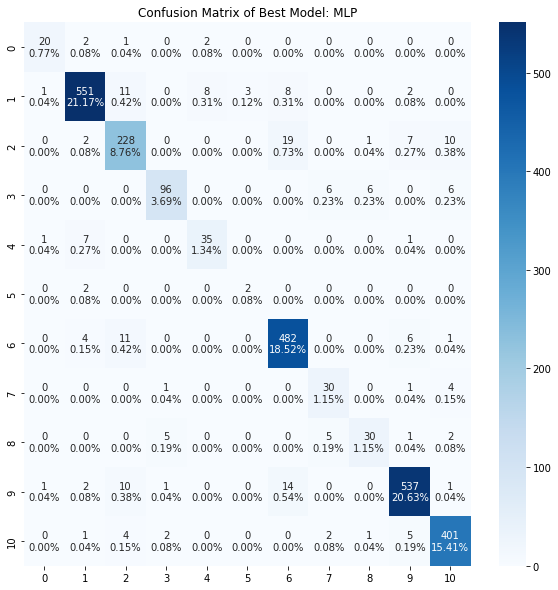

In [ ]:
show_confusion_matrix(best_MLP_pipe, X_test, y_test, 'Confusion Matrix of Best Model: MLP')

## Βελτιστοποίηση του Ταξινομητή Support Vector Machine (SVM)

O SVM είναι γνωστό ότι είναι αργός οπότε για να μπορέσουμε να τον εκπαιδεύσουμε σε λογικό χρόνο ορίζουμε έναν συγκεκριμένο λογικό αριθμό από δείγματα από κάθε κλάση(δεδομένου ότι έχουμε και 11 κλάσεις η εκπαίδευση με όλα τα δείγματα αργεί εξωφρενικά). Κάνοντας oversampling και στην συνέχεια undersampling καταφέρνουμε να εκπαιδεύσουμε με τον ίδιο αριθμό δειγμάτων από κάθε κλάση (περίπου **500** δείγματα από την κάθε κλάση). Έτσι συγρόνως εξισσοροπούμε το dataset και έχουμε καλύτερα αποτελέσματα στις κλάσεις με λίγα σχετικά δείγματα (π.χ. plm και οι άλλες που σημειώθηκαν παραπάνω). Παρατηρούμε ότι στο πρόβλημά μας οι τιμές των αριθμητικών χαρακτηριστικών κυμαίνονται στην ίδια περίπου κλίμακα αλλά δοκιμάσουμε τον standard scaler και φαίνεται ότι καταφέρνει να βελτιώσει αρκετά την επίδοση.
Οι μετασχηματισμοί που χρησιμοποιούνται και τα εύρη τιμών των υπερπαραμέτρων που τους αφορούν επιλέγονται όπως και στο preprocessing της διαδικασίας εκπαίδευσης του MLP Classifier. Όσον αφορά τον ίδιο τον ταξινομητή SVM, θέτουμε/δοκιμάζουμε τιμές τις εξής υπερπαραμέτρους (μέσω optuna θα επιλεγούν οι καλύτερες):

- **C**: η παράμετρος regularization για την αποφυγή φαινομένων overfitting.
- **kernel**: ο πυρήνας του SVM αλγορίθμου.
- **degree**: η τάξη του πολυωνύμου στην περίπτωση του πολυωνυμικού πυρήνα.
- **gamma**: ο συντελεστής πυρήνα όταν επιλέγουμε kernel έναν από τους 'poly', 'rbf', 'sigmoid'.
- **tol**: η ανοχή στον τερματισμό του κριτηρίο σύγκλισης.

Οι βέλτιστες τιμές υπερπαραμέτρων αναζητούνται με χρήση Optuna αρχικά για 15 tasks. Θα δοκιμάσουμε και με περισσότερα (βλέπε παρακάτω).

In [112]:
def balance(X_train, y_train, m=300):
    """
    balances train set so all classes consist of m samples 
    """
    #we are going to use both over & under sampler in order to have m elements of each class in train set
    
    # # elements of each class in train set:
    elements = [101, 2334, 1070, 458, 176, 14, 2013, 144, 172, 2265, 1661]
    #need for the oversampling
    max_ = max(elements)
    
    sampling_strategy = {}
    for i, count in enumerate(elements):
        if count > m:
            sampling_strategy[i]= max_
        else:
            sampling_strategy[i] = m

    ros = RandomOverSampler(sampling_strategy=sampling_strategy)
    ros = RandomOverSampler(sampling_strategy=sampling_strategy)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    for i, count in enumerate(elements):
            sampling_strategy[i]= m
    ros = RandomUnderSampler(sampling_strategy=sampling_strategy)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
    return X_train, y_train

In [27]:
def objective(trial, X_train, y_train):
    
    ## Hyperparameters for variance thresholding
    vthreshold = trial.suggest_loguniform('vthres', 1e-7, 1e-5)   
    ## Hyperparameters for Principal Component Analysis
    n_components = trial.suggest_int('pca_n', 20,60,10)
    
    # Hyperparameters of SVM Classifier
    C = trial.suggest_float('C', 1,1E4)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'sigmoid', 'rbf'])
    degree = trial.suggest_int('degree', 3, 9, 2)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    tol = trial.suggest_loguniform('tol', 1e-4, 1e-2)
    
    # Define Classifier
    clf = SVC(probability = True, C = C, kernel = kernel, gamma = gamma, tol = tol
                 ,degree = degree,
             )
    
    # initialize transformers with optuna hyperparameters
    selector = VarianceThreshold(threshold=vthreshold)
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)
   
    
    #balance train set 
    #we are going to use both over & under sampler in order to have 300 elements of each class in train set
    m = 300
    X_train, y_train = balance(X_train, y_train, m)
    
    
    # Define Pipe
    pipe = Pipeline(steps=[('selector', selector),
                        ('scaler', scaler), 
                        ('pca', pca), 
                        ('estimator', clf)], memory = 'tmp')

    # Train with Cross-Validation

    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')
    
    return np.mean(scores)

In [28]:
study2 = optuna.create_study(direction='maximize')
study2.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=15)

[I 2022-12-02 14:26:25,842] A new study created in memory with name: no-name-d086f2b4-db77-44b2-adaa-67f3f63f9e71
[I 2022-12-02 14:26:33,793] Trial 0 finished with value: 0.8520422844573453 and parameters: {'vthres': 7.551036284427098e-07, 'pca_n': 50, 'C': 1985.0220109315073, 'kernel': 'poly', 'degree': 7, 'gamma': 'auto', 'tol': 0.0007197980735309855}. Best is trial 0 with value: 0.8520422844573453.
[I 2022-12-02 14:26:43,125] Trial 1 finished with value: 0.9324554312269486 and parameters: {'vthres': 1.293896224131032e-07, 'pca_n': 60, 'C': 4752.020579119017, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'tol': 0.000386999099788241}. Best is trial 1 with value: 0.9324554312269486.
[I 2022-12-02 14:26:49,393] Trial 2 finished with value: 0.9047320603175013 and parameters: {'vthres': 9.198167447521438e-07, 'pca_n': 50, 'C': 7394.056162993765, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto', 'tol': 0.0002008556439778197}. Best is trial 1 with value: 0.9324554312269486.
[I 2022-12-02 14:

In [29]:
optuna.visualization.plot_param_importances(study2)

In [30]:
optuna.visualization.plot_slice(study2)


In [31]:
optuna.visualization.plot_optimization_history(study2)

Παραρούμε ότι με τις παραμέτρους που δοκιμάζουμε ο αλγόριθμος optimization καταφέρνει να συγκλίνει από πολύ νωρίς. Θα ξανατρέξουμε τον αλγόριθμο και αυτή την φορά θα κρατήσουμε 500 δείγματα από κάθε κλάση (αυτή την φορά με λιγότερα trials). Παρατηρούμε ότι τα εύρη των τιμών που δοκιμάζουμε είναι καλά επιλεγμένα οπότε απλά περιορίζουμε λίγο το εύρος με βάση το slice plot (π.χ. παρατηρούμε ότι μεγάλα C δεν δίνουν καλά αποτελέσματα). 

In [118]:
def objective(trial, X_train, y_train):
    
    ## Hyperparameters for variance thresholding
    vthreshold = trial.suggest_loguniform('vthres', 1e-7, 1e-5)   
    ## Hyperparameters for Principal Component Analysis
    n_components = trial.suggest_int('pca_n', 20,60,10)
    
    # Hyperparameters of SVM Classifier
    C = trial.suggest_float('C', 1,1E3)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'sigmoid', 'rbf'])
    degree = trial.suggest_int('degree', 3, 9, 2)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    tol = trial.suggest_loguniform('tol', 1e-4, 1e-2)
    
    # Define Classifier
    clf = SVC(#probability = True,  #Σε κάθε περίπτωση, θέτουμε την παράμετρο probability = True, ώστε να μπορούμε να κάνουμε 2 cross-val
              C = C, kernel = kernel, gamma = gamma, tol = tol
                 , degree = degree,
             )
    
    # initialize transformers with optuna hyperparameters
    selector = VarianceThreshold(threshold=vthreshold)
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)
              
    #balance train set 
    #we are going to use both over & under sampler in order to have 450 elements of each class in train set
    m = 450
    X_train, y_train = balance(X_train, y_train, m)
    
    
    # Define Pipe
    pipe = Pipeline(steps=[('selector', selector),
                        ('scaler', scaler), 
                        ('pca', pca), 
                        ('estimator', clf)], memory = 'tmp')

    # Train with Cross-Validation

    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')
    return np.mean(scores)

In [127]:
study2 = optuna.create_study(direction='maximize')
study2.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=20)

[I 2022-12-06 02:36:37,797] A new study created in memory with name: no-name-ca5feeaa-1633-4809-8c65-c26677f6da66
[I 2022-12-06 02:36:44,866] Trial 0 finished with value: 0.19501173105216807 and parameters: {'vthres': 1.179777608995872e-06, 'pca_n': 20, 'C': 596.7470367295529, 'kernel': 'sigmoid', 'degree': 7, 'gamma': 'auto', 'tol': 0.00024230309433002768}. Best is trial 0 with value: 0.19501173105216807.
[I 2022-12-06 02:36:51,285] Trial 1 finished with value: 0.3384922494776136 and parameters: {'vthres': 1.3156310288356086e-06, 'pca_n': 40, 'C': 913.3833158185023, 'kernel': 'sigmoid', 'degree': 9, 'gamma': 'auto', 'tol': 0.003432632318595592}. Best is trial 1 with value: 0.3384922494776136.
[I 2022-12-06 02:37:38,305] Trial 2 finished with value: 0.782248472332313 and parameters: {'vthres': 2.3801526564862463e-06, 'pca_n': 20, 'C': 39.824934593324784, 'kernel': 'linear', 'degree': 5, 'gamma': 'scale', 'tol': 0.0017573294376426545}. Best is trial 2 with value: 0.782248472332313.
[I 2

In [128]:
optuna.visualization.plot_optimization_history(study2)

In [129]:
optuna.visualization.plot_param_importances(study2)


In [130]:
optuna.visualization.plot_slice(study2)


In [ ]:
#ΕΔΩ 350 και περισσότερα trials 
#θα κρατήσουμε ποιες από τις δύο αναθέσεις υπερπαραμέτρων δίνει το καλύτερο αποτέλεσμα στο test set.
def objective(trial, X_train, y_train):
    
    ## Hyperparameters for variance thresholding
    vthreshold = trial.suggest_loguniform('vthres', 1e-7, 1e-5)   
    ## Hyperparameters for Principal Component Analysis
    n_components = trial.suggest_int('pca_n', 20,60,10)
    
    # Hyperparameters of SVM Classifier
    C = trial.suggest_float('C', 1,500)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'sigmoid', 'rbf'])
    degree = trial.suggest_int('degree', 3, 9, 2)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    tol = trial.suggest_loguniform('tol', 1e-4, 1e-2)
    
    # Define Classifier
    clf = SVC(#probability = True,  #Σε κάθε περίπτωση, θέτουμε την παράμετρο probability = True, ώστε να μπορούμε να κάνουμε 2 cross-val
              C = C, kernel = kernel, gamma = gamma, tol = tol
                 , degree = degree,
             )
    
    # initialize transformers with optuna hyperparameters
    selector = VarianceThreshold(threshold=vthreshold)
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)
              
    #balance train set 
    #we are going to use both over & under sampler in order to have 350 elements of each class in train set
    m = 350
    X_train, y_train = balance(X_train, y_train, m)
    
    
    # Define Pipe
    pipe = Pipeline(steps=[('selector', selector),
                        ('scaler', scaler), 
                        ('pca', pca), 
                        ('estimator', clf)], memory = 'tmp')

    # Train with Cross-Validation

    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')
    return np.mean(scores)

study2 = optuna.create_study(direction='maximize')
study2.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=60)

[I 2022-12-06 16:59:06,052] A new study created in memory with name: no-name-81530c61-09d9-4708-89e5-ccc061b18c1a
[I 2022-12-06 16:59:09,561] Trial 0 finished with value: 0.9313852879105049 and parameters: {'vthres': 1.955677789997892e-06, 'pca_n': 50, 'C': 221.20381832551337, 'kernel': 'rbf', 'degree': 9, 'gamma': 'auto', 'tol': 0.006800460046055503}. Best is trial 0 with value: 0.9313852879105049.
[I 2022-12-06 16:59:12,818] Trial 1 finished with value: 0.8437033624336767 and parameters: {'vthres': 1.3951457959372457e-07, 'pca_n': 50, 'C': 328.7187342843057, 'kernel': 'poly', 'degree': 7, 'gamma': 'scale', 'tol': 0.003303080188264824}. Best is trial 0 with value: 0.9313852879105049.
[I 2022-12-06 16:59:16,407] Trial 2 finished with value: 0.9375482890510931 and parameters: {'vthres': 1.8416014324728138e-06, 'pca_n': 60, 'C': 427.89770914622153, 'kernel': 'rbf', 'degree': 9, 'gamma': 'auto', 'tol': 0.00014200370235976491}. Best is trial 2 with value: 0.9375482890510931.
[I 2022-12-06 

Δημιουργούμε το pipeline που προκύπτει από τις βέλτιστες υπερπαραμέτρους. Εκπαιδεύουμε το βέλτιστο μοντέλο στο train dataset και αξιολογούμε τις επιδόσεις του στο test set. Στο test set πετυχαίνει f1 - score = 88%. Παρατηρούμε ότι σημαντικό στην βελτίωση της επίδοσης του ταξινομητή στο cross-validation είναι το C (μεγάλες τιμές C τείνει να δημιουργεί προβλήματα overfitting για αυτό -δεδομένων και των αποτελεσμάτων του optuna παραπάνω- το εύρος δεν φτάνει μεγάλες τιμές).

In [21]:
best_params = study2.best_params
# Hyperparameters of Preprocessing Transformers
n_components = best_params['pca_n']
vthreshold = best_params['vthres']

# Hyperparameters of SVM Classifier
C = best_params['C']
kernel = best_params['kernel']
degree = best_params['degree']
gamma = best_params['gamma']
tol = best_params['tol']

# Define Best Classifier
clf = SVC(probability = True, C = C, kernel = kernel, degree = degree, gamma = gamma, tol = tol)

# Define Best Transformers
selector = VarianceThreshold()#threshold=vthreshold)
scaler = StandardScaler()
pca = PCA(n_components=n_components)

# Define Best Pipe
best_SVM_pipe = Pipeline(steps=[('selector', selector),
                    ('scaler', scaler),  
                    ('pca', pca), 
                    ('estimator', clf)], memory = 'tmp')
print('Best SVM Classifier Performance\n')

metrics2, train_time2, test_time2 = evaluate_best(best_SVM_pipe, X_train, X_test, y_train, y_test, 'macro avg', 2500)
print(f'F1_score (macro) = {100*metrics2["f1-score"]:.3f} %')
print('Train Time = '+str(1000*train_time2)+' msec')
print('Evaluation Time = '+str(1000*test_time2)+' msec\n')

Best SVM Classifier Performance

              precision    recall  f1-score   support

           0       0.83      0.96      0.89        25
           1       0.97      0.96      0.96       584
           2       0.91      0.91      0.91       267
           3       0.90      0.91      0.91       114
           4       0.83      0.80      0.81        44
           5       0.60      0.75      0.67         4
           6       0.96      0.96      0.96       504
           7       0.81      0.81      0.81        36
           8       0.88      0.70      0.78        43
           9       0.97      0.98      0.97       566
          10       0.97      0.97      0.97       416

    accuracy                           0.95      2603
   macro avg       0.88      0.88      0.88      2603
weighted avg       0.95      0.95      0.95      2603

F1_score (macro) = 87.652 %
Train Time = 36560.15658378601 msec
Evaluation Time = 1698.9736557006836 msec



Ας δοκιμάσουμε τώρα να κάνουμε την εκπαίδευση απλά με Random Under Sampler με χρήση των παρατηρήσεων που έχουμε συλλέξει μέχρι τώρα για την βελτιστοποίηση.

In [22]:
def objective(trial, X_train, y_train):
    
    ## Hyperparameters for variance thresholding
    vthreshold = trial.suggest_loguniform('vthres', 1e-7, 1e-5)   
    ## Hyperparameters for Principal Component Analysis
    n_components = trial.suggest_int('pca_n', 20,60,10)
    
    # Hyperparameters of SVM Classifier
    C = trial.suggest_float('C', 1,1E3)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'sigmoid', 'rbf'])
    degree = trial.suggest_int('degree', 3, 9, 2)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    tol = trial.suggest_loguniform('tol', 1e-4, 1e-2)
    
    # Define Classifier
    clf = SVC(#probability = True,  #Σε κάθε περίπτωση, θέτουμε την παράμετρο probability = True, ώστε να μπορούμε να κάνουμε 2 cross-val
              C = C, kernel = kernel, gamma = gamma, tol = tol
                 , degree = degree,
             )
    
    # initialize transformers with optuna hyperparameters
    selector = VarianceThreshold(threshold=vthreshold)
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)
              
    #balance train set 
    #we are going to use both over & under sampler in order to have 500 elements of each class in train set
    rus = RandomUnderSampler()
    # Define Pipe
    pipe = Pipeline(steps=[('selector', selector),
                        ('scaler', scaler), 
                        ('pca', pca), 
                        ('sampler', rus),
                        ('estimator', clf)], memory = 'tmp')

    # Train with Cross-Validation

    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1_macro')
    return np.mean(scores)

In [23]:
study2 = optuna.create_study(direction='maximize')
study2.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=30)

[I 2022-12-06 09:34:04,905] A new study created in memory with name: no-name-4be428e3-9698-4f66-bdca-8a9d912f1437
[I 2022-12-06 09:34:06,558] Trial 0 finished with value: 0.16700213761757388 and parameters: {'vthres': 3.557085348788991e-06, 'pca_n': 20, 'C': 956.5061210125322, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'auto', 'tol': 0.00014501740809687245}. Best is trial 0 with value: 0.16700213761757388.
[I 2022-12-06 09:34:08,255] Trial 1 finished with value: 0.30567065689155626 and parameters: {'vthres': 3.980465016168934e-07, 'pca_n': 20, 'C': 692.75235349399, 'kernel': 'poly', 'degree': 9, 'gamma': 'scale', 'tol': 0.008847884822953813}. Best is trial 1 with value: 0.30567065689155626.
[I 2022-12-06 09:34:09,670] Trial 2 finished with value: 0.40325783588005193 and parameters: {'vthres': 4.932037617532877e-06, 'pca_n': 60, 'C': 892.7891106550745, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale', 'tol': 0.008847874392665753}. Best is trial 2 with value: 0.40325783588005193.
[I 2022-

In [25]:
#NO BALANCING
best_params = study2.best_params


# Hyperparameters of Preprocessing Transformers
n_components = best_params['pca_n']
vthreshold = best_params['vthres']

# Hyperparameters of SVM Classifier
C = best_params['C']
kernel = best_params['kernel']
degree = best_params['degree']
gamma = best_params['gamma']
tol = best_params['tol']

# Define Best Classifier
clf = SVC(probability = True, C = C, kernel = kernel, degree = degree, gamma = gamma, tol = tol)

# Define Best Transformers
selector = VarianceThreshold()#threshold=vthreshold)
scaler = StandardScaler()
pca = PCA(n_components=n_components)

# Define Best Pipe
best_SVM_pipe = Pipeline(steps=[('selector', selector),
                    ('scaler', scaler),  
                    ('pca', pca), 
                    ('estimator', clf)], memory = 'tmp')
print('Best SVM Classifier Performance\n')

metrics2, train_time2, test_time2 = evaluate_best(best_SVM_pipe, X_train, X_test, y_train, y_test, 'macro avg', 2500)
print(f'F1_score (macro) = {100*metrics2["f1-score"]:.3f} %')
print('Train Time = '+str(1000*train_time2)+' msec')
print('Evaluation Time = '+str(1000*test_time2)+' msec\n')

Best SVM Classifier Performance

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.97      0.96      0.97       584
           2       0.91      0.91      0.91       267
           3       0.91      0.92      0.91       114
           4       0.83      0.80      0.81        44
           5       0.75      0.75      0.75         4
           6       0.96      0.96      0.96       504
           7       0.81      0.81      0.81        36
           8       0.91      0.70      0.79        43
           9       0.97      0.97      0.97       566
          10       0.96      0.97      0.97       416

    accuracy                           0.95      2603
   macro avg       0.89      0.88      0.89      2603
weighted avg       0.95      0.95      0.95      2603

F1_score (macro) = 88.671 %
Train Time = 36130.4829120636 msec
Evaluation Time = 1676.9967079162598 msec



Παρατηρούμε ότι η επίδοση είναι η ακόμα καλύτερη! Αυτό γιατί είναι γρήγορη η εκπαίδευση και μπορούμε να κάνουμε πολλά trials - φαίνεται να βοηθάνε.
Συγκρίνοντας με το προηγούμενο classification report βλέπουμε ότι βελτιώθηκε το f1-score των περισσότερων μικρών κλάσεων και σε αυτό οφείλεται η βελτίωση.

Για τον βέλτιστο ταξινομητή μετά την διαδικασία εύρεσης βέλτιστων παραμέτρων παρατίθεται ο πίνακες σύγχυσης. 

Best SVM Classifier Performance

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.97      0.96      0.97       584
           2       0.91      0.91      0.91       267
           3       0.90      0.91      0.91       114
           4       0.83      0.80      0.81        44
           5       0.75      0.75      0.75         4
           6       0.96      0.96      0.96       504
           7       0.81      0.81      0.81        36
           8       0.88      0.70      0.78        43
           9       0.97      0.97      0.97       566
          10       0.96      0.97      0.97       416

    accuracy                           0.95      2603
   macro avg       0.89      0.88      0.89      2603
weighted avg       0.95      0.95      0.95      2603



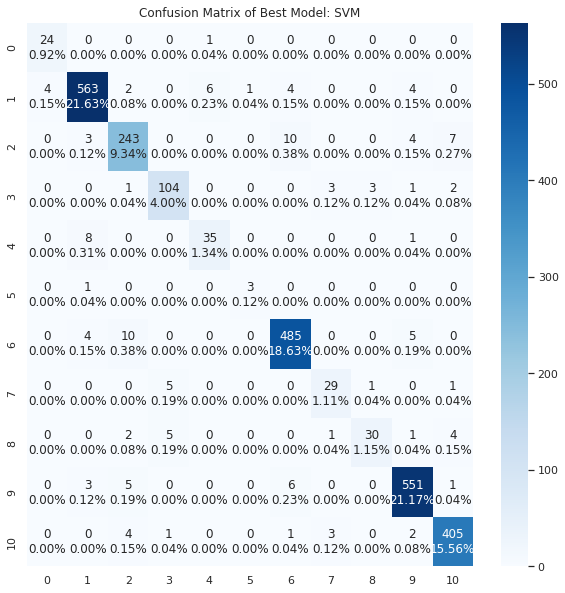

In [30]:
#NO BALANCING
best_params = {'vthres': 2.4024288637769196e-06, 'pca_n': 60, 'C': 587.9390048645758, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'tol': 0.0009769711590453549}


# Hyperparameters of Preprocessing Transformers
n_components = best_params['pca_n']
vthreshold = best_params['vthres']

# Hyperparameters of SVM Classifier
C = best_params['C']
kernel = best_params['kernel']
degree = best_params['degree']
gamma = best_params['gamma']
tol = best_params['tol']

# Define Best Classifier
clf = SVC(probability = True, C = C, kernel = kernel, degree = degree, gamma = gamma, tol = tol)

# Define Best Transformers
selector = VarianceThreshold()#threshold=vthreshold)
scaler = StandardScaler()
pca = PCA(n_components=n_components)

# Define Best Pipe
best_SVM_pipe = Pipeline(steps=[('selector', selector),
                    ('scaler', scaler),  
                    ('pca', pca), 
                    ('estimator', clf)], memory = 'tmp')
print('Best SVM Classifier Performance\n')

metrics2, train_time2, test_time2 = evaluate_best(best_SVM_pipe, X_train, X_test, y_train, y_test, 'macro avg', 2500)


show_confusion_matrix(best_SVM_pipe, X_test, y_test, 'Confusion Matrix of Best Model: SVM')

## Τεκμηρίωση της διαδικασίας
---
Η συνολική διαδικασία που ακολουθήσαμε για να καταλήξουμε από το out-of-the-box στο βέλτιστο μοντέλο για κάθε ταξινομητή μπορεί να συνοψιστεί με βάση το κάτωθι σχήμα:

<img src="https://github.com/rasbt/pattern_classification/raw/master/Images/supervised_learning_flowchart.png" width="60%">

1. **Raw Data Collection**: απλή ανάγνωση των δεδομένων από το ένα εννιαίο .data αρχείου του Kaggle (δεν υπήρχε ανάγκη για κάποιο concatenation αρχείων).  
2. **Data Preprocessing**: το στάδιο συνίσταται από 
    * το **feature extraction**, κατά το οποίο διαγράφουμε τις κολώνες SpeciesID, SpeciesName, Ncodons οι οποίες δεν συνεισφέρουν στο πρόβλημα κατηγοριοποίησης, 
    * το **one-hot encoding** για την sparse αναπαράσταση των μη διατεταγμένων κατηγορικών δεδομένων (της στήλης DNA Type),  
    * το **label encoding** για τις 12 κατηγορίες ζωικών βασιλείων, 
    * την διαγραφή των samples με εσφαλμένες καταχωρήσεις στο dataset. Δεν υπάρχουν missing values. 
3. **Train-Test Split**: διαχωρισμός σε train-test αναλογίας 80/20, ώστε στο πρώτο να μπορούμε να εφαρμόσουμε επακρώς αλγορίθμους μάθησης δίχως να φοβόμαστε τυχόν underfitting.
4. **Main Pipeline**: ο πυρήνας του μοντέλου μάθησης στον οποίο επιλέγουμε τεχνικές 5-fold-validation με στόχο τη μεγιστοποίηση της μετρικής f1-score:
    - **Preprocessing**: περιλαμβάνει feature selection με variance thresholding, κανονικοποίηση δεδομένων με Standard Scaler, υπερδειγματοληψία με Random Oversampler (ή/και υποδειγματοληψία με RandomUnderSamler)και μείωση διαστατικότητας των δεδομένων με PCA. 
    - **Learning Algorithm Training**: αποτελεί το στάδιο εκπαίδευσης του εκτιμητή (MLP ή SVM) με (5-fold) cross-validation πάνω στο train set.
    - **Hyperparameter Optimization**: Τόσο οι υπερπαράμετροι των παραπάνω Transformers, όσο και οι υπερπαράμετροι του κύριου ταξινομητή αναζητούνται και προσδιορίζονται με έτοιμες συναρτήσεις της βιβλιοθήκης Optuna. Δημιουργούμε trials με την χρήση του objective της optuna και κάνουμε αναζήτηση των βέλτιστων υπερπαραμέτρων. Ως επίδοση που θέλουμε να μεγιστοποίησουμε θεωρούμε το F1 macro με 5-fold cross validation στο Train Set. Να σημειωθεί ότι το optuna υποδεικνύει στο documentaion οτι ο αριθμός των trial να είναι 100-1000, ωστόσο το kaggle βάζει χρονικό όριο στο notebook και δεν είναι δυνατό να τρέξουμε τόσα trials. Άλλωστε, παρατηρήσαμε πως γενικά μετά τα 10 trials δεν υπάρχει μεγάλη διαφορά στα αποτελέσματα.
    - **Post-Preprocessing**: ως βέλτιστο μοντέλο μηχανικής μάθησης επιλέγεται εκείνο που έδωσε το μεγαλύτερο ποσοστό ευστοχίας, σύμφωνα με τον συνδυασμό υπερπαραμέτρων που έδωσε το παραπάνω βήμα.
5. **Final Model Evaluation**:  Για το βέλτιστο συνδυασμό υπερπαραμέτρων υπολογίζεται η επίδοση του στο test set αφού εκπαιδευτεί εκ νέου σε ολόκληρο το train dataset. Συγκρίνουμε με την out-of-the-box επίδοση και παραθέτουμε confusion-matrices των μοντέλων για πληρέστερη κατανόηση της επίδοσης τους.

## Αποτελέσματα και παρατηρήσεις
---

Οι παρακάτω πίνακες συνοψίζουν την επίδοση των μοντέλων ως προς τη μετρική F1-score και σημειώνουν και το accuracy για κάθε μοντέλο (βέλτιστο). Υπολογίζεται και η μεταβολή (αύξηση) των μετρικών σε σχέση με την out-of-the-box υλοποίηση, ο χρόνος εκπαίδευσης και ο χρόνος αξιολόγησης των εκτιμητών.

| **Estimator** | **F1-Score (%)**| **F1-Score Change from out-of-the-box (%)**|**Accuracy (%)** | **Accuracy Change from out-of-the-box (%)** |**Train Time (msec)**|**Test Time (msec)**|
| :------------------: |:------------------------------------------: | :-----------: | :-----------: | :-----------: | :-----------:  | :-----------: |
| MLP Classifier         | 82 | +17.2 | 94 | +5.18  |  92107.0 | 83.45
| SVM Classifier         | 89 | +58.05| 94 | +24.54 |  73448.1 | 1600.02


Παρατηρούμε ότι και για τους δύο εκτιμητές οι επίδοση αυξάνεται αημαντικά σε σχέση με την out-of-the-box. Στην περίπτωση του SVM η αύξηση όπως εξηγήθηκε και παραπάνω είναι πειρσσότερο αισθητή (λόγω της default επιλογής kernel που δεν ταιριάζει στο πρόβλημά μας) με αποτέλεσμα ενώ στην out-of-the-box περίπτωση ο MLP Classifier υπερτερούσε του SVM, μετά τη βελτιστοποίηση, το preprocessing και η κατάλληλη επιλογή υπερπαραμέτρων αναδεικνύουν τον SVM ως καλύτερο για το προβλημά μας. Αυτό είναι ενδεικτικό και ενός σημαντικού μειωνεκτήματος του SVM: tα αποτελέσματα εξαρτώνται σε μεγάλο βαθμό από την κατάλληλη επιλογή kernel και της υπερπαραμέτρου μαλακώματος $ C $. Η δεύτερη, γνωστή ως "Cost", ελέγχει την σκληρότητα του περιθωρίου. Για πολύ μεγάλα $ C $, το περιθώριο είναι σκληρό και δεν μπορούν να βρεθούν καθόλου σημεία εντός του περιθωρίου. Για μικρότερα $ C $, το περιθώριο είναι πιο μαλακό και μπορεί να συμπεριλάβει εντός του κάποια σημεία (επιτρέπει δηλαδή σε ορισμένα από τα σημεία να περάσουν στο περιθώριο εάν αυτό επιτρέπει καλύτερη προσαρμογή. Ο προσδιορισμός της πρέπει να γίνει μόνο με cross-validation που μπορεί να είναι ακριβή υπολογιστικά αν έχουμε πολλά δεδομένα.


Επιπλέον, κανονικά ο SVM είναι κανονικά πιο αργός στο training και αυτό οφείλεται στο ότι λύνει το associated Lagrangian δυαδικό πρόβλημα : Η κλιμάκωση με τον αριθμό των δειγμάτων $ N $ είναι στη χειρότερη $ {O} [N ^ 3] $ και  $ {O} [N ^ 2] $ για αποτελεσματικές υλοποιήσεις (πρόβλημα βελτιστοποίησης με αριθμό παραμέτρων ίσο με τον αριθμό των training instances). Επειδή εφώ έχουμε στον SVM χρησιμοποιήσει GPU πράγμα που δεν ήταν διαθέσιμο για τον MLP οπότε ΔΕΝ είναι συγκρίσιμοι οι χρόνοι. Όσον αφορά το inference time, ενώ ο MLP Classifier υπολογίζει απλώς πολλαπλασιασμούς πινάκων και εφαρμόζει μη γραμμικότητες, ο SVM ταξινομητής αποφασίζει σε ποια πλευρά του decision boundary ανήκει κάθε σημείο, χρησιμοποιώντας cosine products. Σε σύγκριση βέβεαι με ταξινομητές βασισμένους σε στιγμιότυπα (instance-based) όπως ο kNN όπου για κάθε δείγμα του test πρέπει να υπολογίσουμε την απόστασή από όλα τα σημεία του train, εδώ εφόσον εκπαιδευτεί το κάθε μοντέλο, η φάση πρόβλεψης είναι πολύ γρήγορη. 

Από τα confusion matrices, βλέπουμε ότι τα περισσότερα δείγματα ταξινομούνται σωστά που είναι αναμενόμενο δεδομένου του υψηλού accuracy που πετυχαίνουμε. Παρατηρούμε ότι στα ζωικά βασίλεια bct, vrl, pln, vrt που αποτελούν τις πιο πολυπληθείς κατηγορίες του dataset (unbalanced dataset) τα λάθη είναι λίγα, ενώ έχουμε περισσότερα (ειδικά δεδομένου του πλήθους τους) στις κλάσεις όπως το plm που εμφανίζονται σπανιότερα στο dataset. 

Η ανωτερότητα του SVM συγκριτικά με τον MLP (δεδομένου ότι είναι βέλτιστα επιλεγμένες οι υπερπαράμετροι και για τους δύο) δεν μας εκπλήσει. Στο documentation που υπάρχει γύρω από αυτούς τους δύο ταξινομητές είναι διαδεδομένη η ανωτερότητα του SVM έναντι του NN (παρόλο που προφανώς εξαρτάται και από το dataset, οι εξαιρέσεις είναι μάλλον λίγες). Όπως είπαμε και παραπάνω, τα μοντέλα αυτά είναι ουσιαστικά διαφορετικά και φαίνεται να δουλεύει πολύ καλύτερα για το πρόβλημα ταξινόμησης η μέθοδος ελαχιστοποίησης της aggregate απόστασης μεταξύ των maximum-margin hyperplane και support vectors. Αναλυτικότερα, εξαρτώνται από σχετικά λίγα διανύσματα υποστήριξης πράγμα που τα καθιστά "robust" μοντέλα (με το επιπλέον πλεονέκτημα μικρών απαιτήσεων σε μνήμη). Γενικά, ισχύει επίσης ότι επειδή ο SVM επηρεάζεται μόνο από σημεία κοντά στο περιθώριο, λειτουργεί καλά με δεδομένα υψηλών διαστάσεων (δεδομένου ότι υπάρχουν προβλήματα με #διαστάσεων > #features, το πρόβλημά μας δεν έχει τόσες πολλές διαστάσεις).

## Συμπεράσματα
---
Επιλέγουμε τον ταξινομητή SVM. Tο τελικό μοντέλο προτίμησής μας είναι το βέλτιστο pipeline με τον ταξινομητή αυτό (**SVM**). Επιθυμούμε να έχουμε υψηλό F1-score (ταυτόχρονα πετυχαίνει και υψηλό accuracy  ~ 94%). Να σημειώσουμε ότι δεν πρόκειται για ένα real-time σύστημα οπότε εφόσον δεν είναι κρίσιμη η γρήγορη απόκριση δεν είναι προτεραιότητά μας να έχουμε μικρούς train και inference χρόνους (εδικά αν έχουμε επαρκής υπολογιστικούς πόρους). Βέβαια, ο επιπλέον χρόνος αυτός δεν αυξάνει εντυπωσιακή αύξηση στην επίδοση οπότε αν ο χρόνος απόκρισης θεωρείται σημαντικός (συγκριτικά) ο MLP Classifier μάλλον είναι προτιμότερος (γενικά στρεφόμαστε στα SVMs όταν άλλες απλούστερες, ταχύτερες και λιγότερο απαιτητικές μέθοδοι έχουν αποδειχθεί ανεπαρκείς για τις ανάγκες του προβλήματος).

Ακολουθούν τα αντίστοιχα bar plot σύγκρισης με την out-of-the-box επίδοση για τους δύο ταξινομητές:

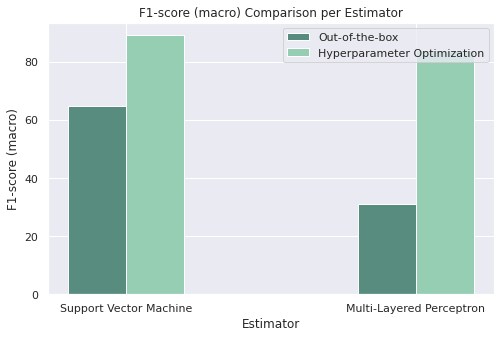

In [31]:
best_metrics = [89, 84]
outofthebox_metrics = [64.796,30.954]
fig = plt.figure(figsize=(8,5))

model_labels = ['Support Vector Machine', 'Multi-Layered Perceptron']
indices = np.arange(len(model_labels))

width = 0.2

# Plot metrics after hyperparameter optimization

plt.bar(indices, outofthebox_metrics, color = colors[0],
      width = width, label = 'Out-of-the-box')

# Plot metrics of out-of-the-box for comparison
plt.bar(indices + width, best_metrics, color =colors[1], width=width, label = 'Hyperparameter Optimization')

plt.xticks(ticks=indices+width/2, labels=model_labels)
plt.xlabel("Estimator")
plt.ylabel("F1-score (macro)")
plt.title('F1-score (macro) Comparison per Estimator')
plt.legend()

plt.show()